In [1]:
# Import libraries and modules
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
print(np.__version__)
print(tf.__version__)
np.set_printoptions(threshold=np.inf)

1.18.5
2.3.0


# Local Development

## Arguments

In [2]:
arguments = {}
# File arguments.
arguments["train_file_pattern"] = "gs://machine-learning-1234-bucket/gan/data/cifar10_car/train*.tfrecord"
arguments["eval_file_pattern"] = "gs://machine-learning-1234-bucket/gan/data/cifar10_car/test*.tfrecord"
arguments["output_dir"] = "gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model"

# Training parameters.
arguments["tf_version"] = 2.2
arguments["use_graph_mode"] = True
arguments["distribution_strategy"] = ""
arguments["write_summaries"] = False
arguments["num_epochs"] = 30
arguments["train_dataset_length"] = 10000
arguments["train_batch_size"] = 32
arguments["input_fn_autotune"] = False
arguments["log_step_count_steps"] = 100
arguments["save_summary_steps"] = 100
arguments["save_checkpoints_steps"] = 10000
arguments["keep_checkpoint_max"] = 10
arguments["export_every_growth_phase"] = True

# Eval parameters.
arguments["eval_batch_size"] = 32
arguments["eval_steps"] = 100

# Image parameters.
arguments["height"] = 32
arguments["width"] = 32
arguments["depth"] = 3

# Shared network parameters.
arguments["num_steps_until_growth"] = 5000
arguments["use_equalized_learning_rate"] = True

# Full lists for full 1024x1024 network growth.
full_conv_num_filters = [[512, 512], [512, 512], [512, 512], [512, 512], [256, 256], [128, 128], [64, 64], [32, 32], [16, 16]]
full_conv_kernel_sizes = [[4, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
full_conv_strides = [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]
num_conv_blocks = min(4, len(full_conv_num_filters))
arguments["conv_num_filters"] = full_conv_num_filters[0:num_conv_blocks]
arguments["conv_kernel_sizes"] = full_conv_kernel_sizes[0:num_conv_blocks]
arguments["conv_strides"] = full_conv_strides[0:num_conv_blocks]

# Generator parameters.
arguments["generator_latent_size"] = 512
arguments["generator_normalize_latents"] = True
arguments["generator_use_pixel_norm"] = True
arguments["generator_pixel_norm_epsilon"] = 1e-8
arguments["generator_projection_dims"] = [4, 4, 512]
arguments["generator_leaky_relu_alpha"] = 0.2
arguments["generator_final_activation"] = "tanh"
arguments["generator_l1_regularization_scale"] = 0.
arguments["generator_l2_regularization_scale"] = 0.
arguments["generator_optimizer"] = "Adam"
arguments["generator_learning_rate"] = 0.001
arguments["generator_adam_beta1"] = 0.0
arguments["generator_adam_beta2"] = 0.99
arguments["generator_adam_epsilon"] = 1e-8
arguments["generator_clip_gradients"] = None
arguments["generator_train_steps"] = 1

# Discriminator hyperparameters.
arguments["discriminator_use_minibatch_stddev"] = True
arguments["discriminator_minibatch_stddev_group_size"] = 4
arguments["discriminator_minibatch_stddev_averaging"] = True
arguments["discriminator_leaky_relu_alpha"] = 0.2
arguments["discriminator_l1_regularization_scale"] = 0.
arguments["discriminator_l2_regularization_scale"] = 0.
arguments["discriminator_optimizer"] = "Adam"
arguments["discriminator_learning_rate"] = 0.001
arguments["discriminator_adam_beta1"] = 0.0
arguments["discriminator_adam_beta2"] = 0.99
arguments["discriminator_adam_epsilon"] = 1e-8
arguments["discriminator_clip_gradients"] = None
arguments["discriminator_gradient_penalty_coefficient"] = 10.0
arguments["discriminator_epsilon_drift"] = 0.001
arguments["discriminator_train_steps"] = 1


In [3]:
def calc_generator_discriminator_conv_layer_properties(
        conv_num_filters, conv_kernel_sizes, conv_strides, depth):
    """Calculates generator and discriminator conv layer properties.

    Args:
        num_filters: list, nested list of ints of the number of filters
            for each conv layer.
        kernel_sizes: list, nested list of ints of the kernel sizes for
            each conv layer.
        strides: list, nested list of ints of the strides for each conv
            layer.
        depth: int, depth dimension of images.

    Returns:
        Nested lists of conv layer properties for both generator and
            discriminator.
    """
    def make_generator(num_filters, kernel_sizes, strides, depth):
        """Calculates generator conv layer properties.

        Args:
            num_filters: list, nested list of ints of the number of filters
                for each conv layer.
            kernel_sizes: list, nested list of ints of the kernel sizes for
                each conv layer.
            strides: list, nested list of ints of the strides for each conv
                layer.
            depth: int, depth dimension of images.

        Returns:
            Nested list of conv layer properties for generator.
        """
        # Get the number of growths.
        num_growths = len(num_filters) - 1

        # Make base block.
        in_out = num_filters[0]
        base = [
            [kernel_sizes[0][i]] * 2 + in_out + [strides[0][i]] * 2
            for i in range(len(num_filters[0]))
        ]
        blocks = [base]

        # Add growth blocks.
        for i in range(1, num_growths + 1):
            in_out = [[blocks[i - 1][-1][-3], num_filters[i][0]]]
            block = [[kernel_sizes[i][0]] * 2 + in_out[0] + [strides[i][0]] * 2]
            for j in range(1, len(num_filters[i])):
                in_out.append([block[-1][-3], num_filters[i][j]])
                block.append(
                    [kernel_sizes[i][j]] * 2 + in_out[j] + [strides[i][j]] * 2
                )
            blocks.append(block)

        # Add toRGB conv.
        blocks[-1].append([1, 1, blocks[-1][-1][-3], depth] + [1] * 2)

        return blocks

    def make_discriminator(generator):
        """Calculates discriminator conv layer properties.

        Args:
            generator: list, nested list of conv layer properties for
                generator.

        Returns:
            Nested list of conv layer properties for discriminator.
        """
        # Reverse generator.
        discriminator = generator[::-1]

        # Reverse input and output shapes.
        discriminator = [
            [
                conv[0:2] + conv[2:4][::-1] + conv[-2:]
                for conv in block[::-1]
            ]
            for block in discriminator
        ]

        return discriminator

    # Calculate conv layer properties for generator using args.
    generator = make_generator(
        conv_num_filters, conv_kernel_sizes, conv_strides, depth
    )

    # Calculate conv layer properties for discriminator using generator
    # properties.
    discriminator = make_discriminator(generator)

    return generator, discriminator


def split_up_generator_conv_layer_properties(
        generator, num_filters, strides, depth):
    """Splits up generator conv layer properties into lists.

    Args:
        generator: list, nested list of conv layer properties for
            generator.
        num_filters: list, nested list of ints of the number of filters
            for each conv layer.
        strides: list, nested list of ints of the strides for each conv
            layer.
        depth: int, depth dimension of images.

    Returns:
        Nested lists of conv layer properties for generator.
    """
    generator_base_conv_blocks = [generator[0][0:len(num_filters[0])]]

    generator_growth_conv_blocks = []
    if len(num_filters) > 1:
        generator_growth_conv_blocks = generator[1:-1] + [generator[-1][:-1]]

    generator_to_rgb_layers = [
        [[1] * 2 + [num_filters[i][0]] + [depth] + [strides[i][0]] * 2]
        for i in range(len(num_filters))
    ]

    return (generator_base_conv_blocks,
            generator_growth_conv_blocks,
            generator_to_rgb_layers)


def split_up_discriminator_conv_layer_properties(
        discriminator, num_filters, strides, depth):
    """Splits up discriminator conv layer properties into lists.

    Args:
        discriminator: list, nested list of conv layer properties for
            discriminator.
        num_filters: list, nested list of ints of the number of filters
            for each conv layer.
        strides: list, nested list of ints of the strides for each conv
            layer.
        depth: int, depth dimension of images.

    Returns:
        Nested lists of conv layer properties for discriminator.
    """
    discriminator_from_rgb_layers = [
        [[1] * 2 + [depth] + [num_filters[i][0]] + [strides[i][0]] * 2]
        for i in range(len(num_filters))
    ]

    if len(num_filters) > 1:
        discriminator_base_conv_blocks = [discriminator[-1]]
    else:
        discriminator_base_conv_blocks = [discriminator[-1][1:]]

    discriminator_growth_conv_blocks = []
    if len(num_filters) > 1:
        discriminator_growth_conv_blocks = [discriminator[0][1:]] + discriminator[1:-1]
        discriminator_growth_conv_blocks = discriminator_growth_conv_blocks[::-1]

    return (discriminator_from_rgb_layers,
            discriminator_base_conv_blocks,
            discriminator_growth_conv_blocks)


In [4]:
# Get conv layer properties for generator and discriminator.
(generator,
 discriminator) = calc_generator_discriminator_conv_layer_properties(
    arguments["conv_num_filters"],
    arguments["conv_kernel_sizes"],
    arguments["conv_strides"],
    arguments["depth"]
)

# Split up generator properties into separate lists.
(generator_base_conv_blocks,
 generator_growth_conv_blocks,
 generator_to_rgb_layers) = split_up_generator_conv_layer_properties(
    generator,
    arguments["conv_num_filters"],
    arguments["conv_strides"],
    arguments["depth"]
)
arguments["generator_base_conv_blocks"] = generator_base_conv_blocks
arguments["generator_growth_conv_blocks"] = generator_growth_conv_blocks
arguments["generator_to_rgb_layers"] = generator_to_rgb_layers

# Split up discriminator properties into separate lists.
(discriminator_from_rgb_layers,
 discriminator_base_conv_blocks,
 discriminator_growth_conv_blocks) = split_up_discriminator_conv_layer_properties(
    discriminator,
    arguments["conv_num_filters"],
    arguments["conv_strides"],
    arguments["depth"]
)
arguments["discriminator_from_rgb_layers"] = discriminator_from_rgb_layers
arguments["discriminator_base_conv_blocks"] = discriminator_base_conv_blocks
arguments["discriminator_growth_conv_blocks"] = discriminator_growth_conv_blocks

In [5]:
arguments

{'train_file_pattern': 'gs://machine-learning-1234-bucket/gan/data/cifar10_car/train*.tfrecord',
 'eval_file_pattern': 'gs://machine-learning-1234-bucket/gan/data/cifar10_car/test*.tfrecord',
 'output_dir': 'gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model',
 'tf_version': 2.2,
 'use_graph_mode': True,
 'distribution_strategy': '',
 'write_summaries': False,
 'num_epochs': 30,
 'train_dataset_length': 10000,
 'train_batch_size': 32,
 'input_fn_autotune': False,
 'log_step_count_steps': 100,
 'save_summary_steps': 100,
 'save_checkpoints_steps': 10000,
 'keep_checkpoint_max': 10,
 'export_every_growth_phase': True,
 'eval_batch_size': 32,
 'eval_steps': 100,
 'height': 32,
 'width': 32,
 'depth': 3,
 'num_steps_until_growth': 5000,
 'use_equalized_learning_rate': True,
 'conv_num_filters': [[512, 512], [512, 512], [512, 512], [512, 512]],
 'conv_kernel_sizes': [[4, 3], [3, 3], [3, 3], [3, 3]],
 'conv_strides': [[1, 1], [1, 1], [1, 1], [1, 1]],
 'generator_latent_size': 512,


## input.py

In [6]:
def preprocess_image(image):
    """Preprocess image tensor.

    Args:
        image: tensor, input image with shape
            [batch_size, height, width, depth].

    Returns:
        Preprocessed image tensor with shape
            [batch_size, height, width, depth].
    """
    # Convert from [0, 255] -> [-1.0, 1.0] floats.
    image = tf.cast(x=image, dtype=tf.float32) * (2. / 255) - 1.0

    return image


def decode_example(protos, params):
    """Decodes TFRecord file into tensors.

    Given protobufs, decode into image and label tensors.

    Args:
        protos: protobufs from TFRecord file.
        params: dict, user passed parameters.

    Returns:
        Image and label tensors.
    """
    # Create feature schema map for protos.
    features = {
        "image_raw": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
        "label": tf.io.FixedLenFeature(shape=[], dtype=tf.int64)
    }

    # Parse features from tf.Example.
    parsed_features = tf.io.parse_single_example(
        serialized=protos, features=features
    )

    # Convert from a scalar string tensor (whose single string has
    # length height * width * depth) to a uint8 tensor with shape
    # [height * width * depth].
    image = tf.io.decode_raw(
        input_bytes=parsed_features["image_raw"], out_type=tf.uint8
    )

    # Reshape flattened image back into normal dimensions.
    image = tf.reshape(
        tensor=image,
        shape=[params["height"], params["width"], params["depth"]]
    )

    # Preprocess image.
    image = preprocess_image(image=image)

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(x=parsed_features["label"], dtype=tf.int32)

    return {"image": image}, label


def set_static_shape(features, labels, batch_size):
    """Sets static shape of batched input tensors in dataset.

    Args:
        features: dict, keys are feature names and values are feature tensors.
        labels: tensor, label data.
        batch_size: int, number of examples per batch.

    Returns:
        Features tensor dictionary and labels tensor.
    """
    features["image"].set_shape(
        features["image"].get_shape().merge_with(
            tf.TensorShape([batch_size, None, None, None])
        )
    )
    labels.set_shape(
        labels.get_shape().merge_with(tf.TensorShape([batch_size]))
    )

    return features, labels


def read_dataset(filename, batch_size, params, training):
    """Reads TF Record data using tf.data, doing necessary preprocessing.

    Given filename, mode, batch size, and other parameters, read TF Record
    dataset using Dataset API, apply necessary preprocessing, and return an
    input function to the Estimator API.

    Args:
        filename: str, file pattern that to read into our tf.data dataset.
        batch_size: int, number of examples per batch.
        params: dict, dictionary of user passed parameters.
        training: bool, if training or not.

    Returns:
        An input function.
    """
    def fetch_dataset(filename):
        """Fetches TFRecord Dataset from given filename.
        Args:
            filename: str, name of TFRecord file.
        Returns:
            Dataset containing TFRecord Examples.
        """
        buffer_size = 8 * 1024 * 1024  # 8 MiB per file
        dataset = tf.data.TFRecordDataset(
            filenames=filename, buffer_size=buffer_size
        )

        return dataset


    def _input_fn():
        """Wrapper input function used by Estimator API to get data tensors.

        Returns:
            Batched dataset object of dictionary of feature tensors and label
                tensor.
        """
        # Create dataset to contain list of files matching pattern.
        dataset = tf.data.Dataset.list_files(
            file_pattern=filename, shuffle=training
        )

        # Repeat dataset files indefinitely if in training.
        if training:
            dataset = dataset.repeat()

        # Parallel interleaves multiple files at once with map function.
        dataset = dataset.apply(
            tf.data.experimental.parallel_interleave(
                map_func=fetch_dataset, cycle_length=64, sloppy=True
            )
        )

        # Shuffle the Dataset TFRecord Examples if in training.
        if training:
            dataset = dataset.shuffle(buffer_size=1024)

        # Decode TF Record Example into a features dictionary of tensors.
        dataset = dataset.map(
            map_func=lambda x: decode_example(
                protos=x,
                params=params
            ),
            num_parallel_calls=(
                tf.contrib.data.AUTOTUNE
                if params["input_fn_autotune"]
                else None
            )
        )

        batch_size = (
            params["train_batch_size"]
            if training
            else params["eval_batch_size"]
        )

        # Batch dataset and drop remainder so there are no partial batches.
        dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)

        # Assign static shape, namely make the batch size axis static.
        dataset = dataset.map(
            map_func=lambda x, y: set_static_shape(
                features=x, labels=y, batch_size=batch_size
            )
        )

        # Prefetch data to improve latency.
        dataset = dataset.prefetch(
            buffer_size=(
                tf.data.experimental.AUTOTUNE
                if params["input_fn_autotune"]
                else 1
            )
        )

        return dataset

    return _input_fn


In [7]:
# train_ds = read_dataset(
#     filename=arguments["train_file_pattern"],
#     batch_size=arguments["train_batch_size"],
#     params=arguments,
#     training=True
# )()
# train_ds

In [8]:
# eval_ds = read_dataset(
#     filename=arguments["eval_file_pattern"],
#     batch_size=arguments["eval_batch_size"],
#     params=arguments,
#     training=False
# )()
# eval_ds

## custom_layers.py

In [9]:
class WeightScaledDense(tf.keras.layers.Dense):
    """Subclassing `Dense` layer to allow equalized learning rate scaling.

    Attributes:
        use_equalized_learning_rate: bool, if want to scale layer weights to
            equalize learning rate each forward pass.
    """
    def __init__(
            self,
            units,
            activation=None,
            use_bias=True,
            kernel_initializer=None,
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=None,
            bias_regularizer=None,
            activity_regularizer=None,
            kernel_constraint=None,
            bias_constraint=None,
            trainable=True,
            use_equalized_learning_rate=False,
            name=None,
            **kwargs):
        """Initializes `Dense` layer.
        Args:
            units: Integer or Long, dimensionality of the output space.
            activation: Activation function (callable). Set it to None to maintain a
              linear activation.
            use_bias: Boolean, whether the layer uses a bias.
            kernel_initializer: Initializer function for the weight matrix.
              If `None` (default), weights are initialized using the default
              initializer used by `tf.compat.v1.get_variable`.
            bias_initializer: Initializer function for the bias.
            kernel_regularizer: Regularizer function for the weight matrix.
            bias_regularizer: Regularizer function for the bias.
            activity_regularizer: Regularizer function for the output.
            kernel_constraint: An optional projection function to be applied to the
                kernel after being updated by an `Optimizer` (e.g. used to implement
                norm constraints or value constraints for layer weights). The function
                must take as input the unprojected variable and must return the
                projected variable (which must have the same shape). Constraints are
                not safe to use when doing asynchronous distributed training.
            bias_constraint: An optional projection function to be applied to the
                bias after being updated by an `Optimizer`.
            trainable: Boolean, if `True` also add variables to the graph collection
              `GraphKeys.TRAINABLE_VARIABLES` (see `tf.Variable`).
            use_equalized_learning_rate: bool, if want to scale layer weights to
                equalize learning rate each forward pass.
            name: String, the name of the layer. Layers with the same name will
              share weights, but to avoid mistakes we require reuse=True in such cases.
        """
        super().__init__(
            units=units,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            trainable=trainable,
            name=name,
            **kwargs
        )

        # Whether we will scale weights using He init every forward pass.
        self.use_equalized_learning_rate = use_equalized_learning_rate

    def call(self, inputs):
        """Calls layer and returns outputs.

        Args:
            inputs: tensor, input tensor of shape [batch_size, features].
        """
        if self.use_equalized_learning_rate:
            # Scale kernel weights by He init fade-in constant.
            kernel_shape = [x for x in self.kernel.shape]
            fan_in = kernel_shape[0]
            he_constant = tf.sqrt(x=2. / float(fan_in))
            kernel = self.kernel * he_constant
        else:
            kernel = self.kernel

        rank = len(inputs.shape)
        if rank > 2:
            # Broadcasting is required for the inputs.
            outputs = tf.tensordot(
                a=inputs, b=kernel, axes=[[rank - 1], [0]]
            )
            # Reshape the output back to the original ndim of the input.
            if not context.executing_eagerly():
                shape = inputs.shape.as_list()
                output_shape = shape[:-1] + [self.units]
                outputs.set_shape(shape=output_shape)
        else:
            inputs = tf.cast(x=inputs, dtype=self._compute_dtype)
            if isinstance(inputs, tf.SparseTensor):
                outputs = tf.sparse_tensor_dense_matmul(sp_a=inputs, b=kernel)
            else:
                outputs = tf.matmul(a=inputs, b=kernel)
        if self.use_bias:
            outputs = tf.nn.bias_add(value=outputs, bias=self.bias)
        if self.activation is not None:
            return self.activation(outputs)  # pylint: disable=not-callable

        return outputs


class WeightScaledConv2D(tf.keras.layers.Conv2D):
    """Subclassing `Conv2D` layer to allow equalized learning rate scaling.

    Attributes:
        use_equalized_learning_rate: bool, if want to scale layer weights to
            equalize learning rate each forward pass.
    """
    def __init__(
            self,
            filters,
            kernel_size,
            strides=(1, 1),
            padding="valid",
            data_format="channels_last",
            dilation_rate=(1, 1),
            activation=None,
            use_bias=True,
            kernel_initializer=None,
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=None,
            bias_regularizer=None,
            activity_regularizer=None,
            kernel_constraint=None,
            bias_constraint=None,
            trainable=True,
            use_equalized_learning_rate=False,
            name=None,
            **kwargs):
        """Initializes `Conv2D` layer.
        Args:
            filters: Integer, the dimensionality of the output space (i.e. the number
              of filters in the convolution).
            kernel_size: An integer or tuple/list of 2 integers, specifying the
              height and width of the 2D convolution window.
              Can be a single integer to specify the same value for
              all spatial dimensions.
            strides: An integer or tuple/list of 2 integers,
              specifying the strides of the convolution along the height and width.
              Can be a single integer to specify the same value for
              all spatial dimensions.
              Specifying any stride value != 1 is incompatible with specifying
              any `dilation_rate` value != 1.
            padding: One of `"valid"` or `"same"` (case-insensitive).
            data_format: A string, one of `channels_last` (default) or `channels_first`.
              The ordering of the dimensions in the inputs.
              `channels_last` corresponds to inputs with shape
              `(batch, height, width, channels)` while `channels_first` corresponds to
              inputs with shape `(batch, channels, height, width)`.
            dilation_rate: An integer or tuple/list of 2 integers, specifying
              the dilation rate to use for dilated convolution.
              Can be a single integer to specify the same value for
              all spatial dimensions.
              Currently, specifying any `dilation_rate` value != 1 is
              incompatible with specifying any stride value != 1.
            activation: Activation function. Set it to None to maintain a
              linear activation.
            use_bias: Boolean, whether the layer uses a bias.
            kernel_initializer: An initializer for the convolution kernel.
            bias_initializer: An initializer for the bias vector. If None, the default
              initializer will be used.
            kernel_regularizer: Optional regularizer for the convolution kernel.
            bias_regularizer: Optional regularizer for the bias vector.
            activity_regularizer: Optional regularizer function for the output.
            kernel_constraint: Optional projection function to be applied to the
                kernel after being updated by an `Optimizer` (e.g. used to implement
                norm constraints or value constraints for layer weights). The function
                must take as input the unprojected variable and must return the
                projected variable (which must have the same shape). Constraints are
                not safe to use when doing asynchronous distributed training.
            bias_constraint: Optional projection function to be applied to the
                bias after being updated by an `Optimizer`.
            trainable: Boolean, if `True` also add variables to the graph collection
              `GraphKeys.TRAINABLE_VARIABLES` (see `tf.Variable`).
            use_equalized_learning_rate: bool, if want to scale layer weights to
                equalize learning rate each forward pass.
            name: A string, the name of the layer.
        """
        super().__init__(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            trainable=trainable,
            name=name,
            **kwargs
        )

        # Whether we will scale weights using He init every forward pass.
        self.use_equalized_learning_rate = use_equalized_learning_rate

    def call(self, inputs):
        """Calls layer and returns outputs.
        Args:
            inputs: tensor, input tensor of shape
                [batch_size, height, width, channels].
        """
        if self.use_equalized_learning_rate:
            # Scale kernel weights by He init constant.
            kernel_shape = [x for x in self.kernel.shape]
            fan_in = kernel_shape[0] * kernel_shape[1] * kernel_shape[2]
            he_constant = tf.sqrt(x=2. / float(fan_in))
            kernel = self.kernel * he_constant
        else:
            kernel = self.kernel

        outputs = self._convolution_op(inputs, kernel)

        if self.use_bias:
            if self.data_format == "channels_first":
                if self.rank == 1:
                    # nn.bias_add does not accept a 1D input tensor.
                    bias = tf.reshape(
                        tensor=self.bias, shape=(1, self.filters, 1)
                    )
                    outputs += bias
                else:
                    outputs = tf.nn.bias_add(
                        value=outputs, bias=self.bias, data_format="NCHW"
                    )
            else:
                outputs = tf.nn.bias_add(
                    value=outputs, bias=self.bias, data_format="NHWC"
                )

        if self.activation is not None:
            return self.activation(outputs)
        return outputs


class PixelNormalization(tf.keras.layers.Layer):
    """Normalizes the feature vector in each pixel to unit length.

    Attributes:
        epsilon: float, small value to add to denominator for numerical
            stability.
    """
    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

    def call(self, inputs):
        """Calls PixelNormalization layer with given inputs tensor.

        Args:
            inputs: tensor, image feature vectors.

        Returns:
            Pixel normalized feature vector tensor.
        """
        return inputs * tf.math.rsqrt(
            x=tf.add(
                x=tf.reduce_mean(
                    input_tensor=tf.square(x=inputs), axis=1, keepdims=True
                ),
                y=self.epsilon
            )
        )


## generators.py

In [10]:
class Generator(object):
    """Generator that takes latent vector input and outputs image.

    Attributes:
        name: str, name of `Generator`.
        kernel_regularizer: `l1_l2_regularizer` object, regularizar for
            kernel variables.
        bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
            variables.
        params: dict, user passed parameters.
        alpha_var: variable, alpha for weighted sum of fade-in of layers.
        conv_layers: list, `Conv2D` layers.
        leaky_relu_layers: list, leaky relu layers that follow `Conv2D`
            layers.
        to_rgb_conv_layers: list, `Conv2D` toRGB layers.
        model: instance of generator `Model`.
    """
    def __init__(
        self,
        kernel_regularizer,
        bias_regularizer,
        name,
        params,
        alpha_var
    ):
        """Instantiates and builds generator network.

        Args:
            kernel_regularizer: `l1_l2_regularizer` object, regularizar for
                kernel variables.
            bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
                variables.
            name: str, name of generator.
            params: dict, user passed parameters.
            alpha_var: variable, alpha for weighted sum of fade-in of layers.
        """
        # Set name of generator.
        self.name = name

        # Store regularizers.
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer

        # Store parameters.
        self.params = params

        # Store reference to alpha variable.
        self.alpha_var = alpha_var

        # Store lists of layers.
        self.conv_layers = []
        self.leaky_relu_layers = []
        self.to_rgb_conv_layers = []

        # Instantiate generator layers.
        self._create_generator_layers()

        # Store current generator model.
        self.model = None

    def use_pixel_norm(self, epsilon=1e-8):
        """Decides based on user parameter whether to use pixel norm or not.

        Args:
            epsilon: float, small value to add to denominator for numerical
                stability.
        Returns:
            Pixel normalized feature vectors if using pixel norm, else
                original feature vectors.
        """
        if self.params["generator_use_pixel_norm"]:
            return PixelNormalization(epsilon=epsilon)
        return None

    def fused_conv2d_act_pixel_norm_block(
        self, conv_layer, activation_layer, inputs
    ):
        """Fused Conv2D, activation, and pixel norm operation block.

        Args:
            conv_layer: instance of `Conv2D` layer.
            activation_layer: instance of `Layer`, such as LeakyRelu layer.
            inputs: tensor, inputs to fused block.

        Returns:
            Output tensor of fused block.
        """
        network = conv_layer(inputs=inputs)
        network = activation_layer(inputs=network)

        # Possibly add pixel normalization to image.
        pixel_norm_layer = self.use_pixel_norm(
            epsilon=self.params["generator_pixel_norm_epsilon"]
        )

        if pixel_norm_layer is not None:
            network = pixel_norm_layer(inputs=network)

        return network

    def _project_latent_vectors(self, latent_vectors):
        """Defines generator network.

        Args:
            latent_vectors: tensor, latent vector inputs of shape
                [batch_size, latent_size].

        Returns:
            Projected image of latent vector inputs.
        """
        projection_height = self.params["generator_projection_dims"][0]
        projection_width = self.params["generator_projection_dims"][1]
        projection_depth = self.params["generator_projection_dims"][2]

        # shape = (
        #     batch_size,
        #     projection_height * projection_width * projection_depth
        # )
        projection = WeightScaledDense(
            units=projection_height * projection_width * projection_depth,
            activation=None,
            kernel_initializer=(
                tf.random_normal_initializer(mean=0., stddev=1.0)
                if self.params["use_equalized_learning_rate"]
                else "he_normal"
            ),
            kernel_regularizer=self.kernel_regularizer,
            bias_regularizer=self.bias_regularizer,
            use_equalized_learning_rate=(
                self.params["use_equalized_learning_rate"]
            ),
            name="projection_dense_layer"
        )(inputs=latent_vectors)

        projection_leaky_relu = tf.keras.layers.LeakyReLU(
            alpha=self.params["generator_leaky_relu_alpha"],
            name="projection_leaky_relu"
        )(inputs=projection)

        # Reshape projection into "image".
        # shape = (
        #     batch_size,
        #     projection_height,
        #     projection_width,
        #     projection_depth
        # )
        projected_image = tf.reshape(
            tensor=projection_leaky_relu,
            shape=[
                -1, projection_height, projection_width, projection_depth
            ],
            name="projected_image"
        )

        # Possibly add pixel normalization to image.
        if self.params["generator_normalize_latents"]:
            pixel_norm_layer = self.use_pixel_norm(
                epsilon=self.params["generator_pixel_norm_epsilon"]
            )

            if pixel_norm_layer is not None:
                projected_image = pixel_norm_layer(inputs=projected_image)

        return projected_image

    def _create_base_conv_layer_block(self):
        """Creates generator base conv layer block.

        Returns:
            List of base block conv layers and list of leaky relu layers.
        """
        # Get conv block layer properties.
        conv_block = self.params["generator_base_conv_blocks"][0]

        # Create list of base conv layers.
        base_conv_layers = [
            WeightScaledConv2D(
                filters=conv_block[i][3],
                kernel_size=conv_block[i][0:2],
                strides=conv_block[i][4:6],
                padding="same",
                activation=None,
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
                    if self.params["use_equalized_learning_rate"]
                    else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                use_equalized_learning_rate=self.params["use_equalized_learning_rate"],
                name="{}_base_layers_conv2d_{}_{}x{}_{}_{}".format(
                    self.name,
                    i,
                    conv_block[i][0],
                    conv_block[i][1],
                    conv_block[i][2],
                    conv_block[i][3]
                )
            )
            for i in range(len(conv_block))
        ]

        base_leaky_relu_layers = [
            tf.keras.layers.LeakyReLU(
                alpha=self.params["generator_leaky_relu_alpha"],
                name="{}_base_conv_leaky_relu_{}".format(self.name, i)
            )
            for i in range(len(conv_block))
        ]

        return base_conv_layers, base_leaky_relu_layers

    def _create_growth_conv_layer_block(self, block_idx):
        """Creates generator growth conv layer block.

        Args:
            block_idx: int, the current growth block's index.

        Returns:
            List of growth block's conv layers and list of growth block's
                leaky relu layers.
        """
        # Get conv block layer properties.
        conv_block = self.params["generator_growth_conv_blocks"][block_idx]

        # Create new growth convolutional layers.
        growth_conv_layers = [
            WeightScaledConv2D(
                filters=conv_block[i][3],
                kernel_size=conv_block[i][0:2],
                strides=conv_block[i][4:6],
                padding="same",
                activation=None,
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
                    if self.params["use_equalized_learning_rate"]
                    else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                use_equalized_learning_rate=self.params["use_equalized_learning_rate"],
                name="{}_growth_layers_conv2d_{}_{}_{}x{}_{}_{}".format(
                    self.name,
                    block_idx,
                    i,
                    conv_block[i][0],
                    conv_block[i][1],
                    conv_block[i][2],
                    conv_block[i][3]
                )
            )
            for i in range(len(conv_block))
        ]

        growth_leaky_relu_layers = [
            tf.keras.layers.LeakyReLU(
                alpha=self.params["generator_leaky_relu_alpha"],
                name="{}_growth_conv_leaky_relu_{}_{}".format(
                    self.name, block_idx, i
                )
            )
            for i in range(len(conv_block))
        ]

        return growth_conv_layers, growth_leaky_relu_layers

    def _create_to_rgb_layers(self):
        """Creates generator toRGB layers of 1x1 convs.

        Returns:
            List of toRGB 1x1 conv layers.
        """
        # Dictionary containing possible final activations.
        final_activation_set = {"sigmoid", "relu", "tanh"}

        # Get toRGB layer properties.
        to_rgb = [
            self.params["generator_to_rgb_layers"][i][0][:]
            for i in range(
                len(self.params["generator_to_rgb_layers"])
            )
        ]

        # Create list to hold toRGB 1x1 convs.
        to_rgb_conv_layers = [
            WeightScaledConv2D(
                filters=to_rgb[i][3],
                kernel_size=to_rgb[i][0:2],
                strides=to_rgb[i][4:6],
                padding="same",
                activation=(
                    self.params["generator_final_activation"].lower()
                    if self.params["generator_final_activation"].lower()
                    in final_activation_set
                    else None
                ),
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
                    if self.params["use_equalized_learning_rate"]
                    else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                use_equalized_learning_rate=self.params["use_equalized_learning_rate"],
                name="{}_to_rgb_layers_conv2d_{}_{}x{}_{}_{}".format(
                    self.name,
                    i,
                    to_rgb[i][0],
                    to_rgb[i][1],
                    to_rgb[i][2],
                    to_rgb[i][3]
                )
            )
            for i in range(len(to_rgb))
        ]

        return to_rgb_conv_layers

    def _create_generator_layers(self):
        """Creates generator layers.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
        """
        (base_conv_layers,
         base_leaky_relu_layers) = self._create_base_conv_layer_block()
        self.conv_layers.append(base_conv_layers)
        self.leaky_relu_layers.append(base_leaky_relu_layers)

        for block_idx in range(
            len(self.params["generator_growth_conv_blocks"])
        ):
            (growth_conv_layers,
             growth_leaky_relu_layers
             ) = self._create_growth_conv_layer_block(block_idx)

            self.conv_layers.append(growth_conv_layers)
            self.leaky_relu_layers.append(growth_leaky_relu_layers)

        self.to_rgb_conv_layers = self._create_to_rgb_layers()

    def _upsample_generator_image(self, image, orig_img_size, block_idx):
        """Upsamples generator intermediate image.
        Args:
            image: tensor, image created by vec_to_img conv block.
            orig_img_size: list, the height and width dimensions of the
                original image before any growth.
            block_idx: int, index of the current vec_to_img growth block.
        Returns:
            Upsampled image tensor.
        """
        # Upsample from s X s to 2s X 2s image.
        upsampled_image = tf.image.resize(
            images=image,
            size=tf.convert_to_tensor(
                value=orig_img_size,
                dtype=tf.int32
            ) * 2 ** block_idx,
            method="nearest",
            name="{}_growth_upsampled_image_{}_{}x{}_{}x{}".format(
                self.name,
                block_idx,
                orig_img_size[0] * 2 ** (block_idx - 1),
                orig_img_size[1] * 2 ** (block_idx - 1),
                orig_img_size[0] * 2 ** block_idx,
                orig_img_size[1] * 2 ** block_idx
            )
        )

        return upsampled_image

    def _build_base_model(self, input_shape, batch_size):
        """Builds generator base model.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
            batch_size: int, fixed number of examples within batch.

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to generator.
        # shape = (batch_size, latent_size)
        inputs = tf.keras.Input(
            shape=input_shape,
            batch_size=batch_size,
            name="{}_inputs".format(self.name)
        )

        # Project latent vectors.
        network = self._project_latent_vectors(latent_vectors=inputs)

        # Get base block layers.
        base_conv_layers = self.conv_layers[0]
        base_leaky_relu_layers = self.leaky_relu_layers[0]
        base_to_rgb_conv_layer = self.to_rgb_conv_layers[0]

        # Pass inputs through layer chain.
        for i in range(len(base_conv_layers)):
            network = self.fused_conv2d_act_pixel_norm_block(
                conv_layer=base_conv_layers[i],
                activation_layer=base_leaky_relu_layers[i],
                inputs=network
            )

        fake_images = base_to_rgb_conv_layer(inputs=network)

        # Define model.
        model = tf.keras.Model(
            inputs=inputs,
            outputs=fake_images,
            name="{}_base".format(self.name)
        )

        return model

    def _build_growth_transition_model(
        self, input_shape, batch_size, block_idx
    ):
        """Builds generator growth transition model.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
            batch_size: int, fixed number of examples within batch.
            block_idx: int, current block index of model progression.

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to generator.
        # shape = (batch_size, latent_size)
        inputs = tf.keras.Input(
            shape=input_shape,
            batch_size=batch_size,
            name="{}_inputs".format(self.name)
        )

        # Project latent vectors.
        network = self._project_latent_vectors(latent_vectors=inputs)

        # Permanent blocks.
        permanent_conv_layers = self.conv_layers[0:block_idx]
        permanent_leaky_relu_layers = self.leaky_relu_layers[0:block_idx]

        # Base block doesn't need any upsampling so handle differently.
        base_conv_layers = permanent_conv_layers[0]
        base_leaky_relu_layers = permanent_leaky_relu_layers[0]

        # Pass inputs through layer chain.
        for i in range(len(base_conv_layers)):
            network = self.fused_conv2d_act_pixel_norm_block(
                conv_layer=base_conv_layers[i],
                activation_layer=base_leaky_relu_layers[i],
                inputs=network
            )

        # Growth blocks require first prev conv layer's image upsampled.
        for i in range(1, len(permanent_conv_layers)):
            # Upsample previous block's image.
            network = self._upsample_generator_image(
                image=network,
                orig_img_size=self.params["generator_projection_dims"][0:2],
                block_idx=i
            )

            block_conv_layers = permanent_conv_layers[i]
            block_leaky_relu_layers = permanent_leaky_relu_layers[i]
            for j in range(0, len(block_conv_layers)):
                network = self.fused_conv2d_act_pixel_norm_block(
                    conv_layer=block_conv_layers[j],
                    activation_layer=block_leaky_relu_layers[j],
                    inputs=network
                )

        # Upsample most recent block conv image for both side chains.
        upsampled_block_conv = self._upsample_generator_image(
            image=network,
            orig_img_size=self.params["generator_projection_dims"][0:2],
            block_idx=len(permanent_conv_layers)
        )

        # Growing side chain.
        growing_conv_layers = self.conv_layers[block_idx]
        growing_leaky_relu_layers = self.leaky_relu_layers[block_idx]
        growing_to_rgb_conv_layer = self.to_rgb_conv_layers[block_idx]

        # Pass inputs through layer chain.
        network = upsampled_block_conv
        for i in range(0, len(growing_conv_layers)):
            network = self.fused_conv2d_act_pixel_norm_block(
                conv_layer=growing_conv_layers[i],
                activation_layer=growing_leaky_relu_layers[i],
                inputs=network
            )

        growing_to_rgb_conv = growing_to_rgb_conv_layer(inputs=network)

        # Shrinking side chain.
        shrinking_to_rgb_conv_layer = self.to_rgb_conv_layers[block_idx - 1]

        # Pass inputs through layer chain.
        shrinking_to_rgb_conv = shrinking_to_rgb_conv_layer(
            inputs=upsampled_block_conv
        )

        # Weighted sum.
        weighted_sum = tf.add(
            x=growing_to_rgb_conv * self.alpha_var,
            y=shrinking_to_rgb_conv * (1.0 - self.alpha_var),
            name="{}_growth_transition_weighted_sum_{}".format(
                self.name, block_idx
            )
        )

        fake_images = weighted_sum

        # Define model.
        model = tf.keras.Model(
            inputs=inputs,
            outputs=fake_images,
            name="{}_growth_transition_{}".format(self.name, block_idx)
        )

        return model

    def _build_growth_stable_model(self, input_shape, batch_size, block_idx):
        """Builds generator growth stable model.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
            batch_size: int, fixed number of examples within batch.
            block_idx: int, current block index of model progression.

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to generator.
        # shape = (batch_size, latent_size)
        inputs = tf.keras.Input(
            shape=input_shape,
            batch_size=batch_size,
            name="{}_inputs".format(self.name)
        )

        # Project latent vectors.
        network = self._project_latent_vectors(latent_vectors=inputs)

        # Permanent blocks.
        permanent_conv_layers = self.conv_layers[0:block_idx + 1]
        permanent_leaky_relu_layers = self.leaky_relu_layers[0:block_idx + 1]

        # Base block doesn't need any upsampling so handle differently.
        base_conv_layers = permanent_conv_layers[0]
        base_leaky_relu_layers = permanent_leaky_relu_layers[0]

        # Pass inputs through layer chain.
        for i in range(len(base_conv_layers)):
            network = self.fused_conv2d_act_pixel_norm_block(
                conv_layer=base_conv_layers[i],
                activation_layer=base_leaky_relu_layers[i],
                inputs=network
            )

        # Growth blocks require first prev conv layer's image upsampled.
        for i in range(1, len(permanent_conv_layers)):
            # Upsample previous block's image.
            network = self._upsample_generator_image(
                image=network,
                orig_img_size=self.params["generator_projection_dims"][0:2],
                block_idx=i
            )

            block_conv_layers = permanent_conv_layers[i]
            block_leaky_relu_layers = permanent_leaky_relu_layers[i]
            for j in range(0, len(block_conv_layers)):
                network = self.fused_conv2d_act_pixel_norm_block(
                    conv_layer=block_conv_layers[j],
                    activation_layer=block_leaky_relu_layers[j],
                    inputs=network
                )

        # Get toRGB layer.
        to_rgb_conv_layer = self.to_rgb_conv_layers[block_idx]

        fake_images = to_rgb_conv_layer(inputs=network)

        # Define model.
        model = tf.keras.Model(
            inputs=inputs,
            outputs=fake_images,
            name="{}_growth_stable_{}".format(self.name, block_idx)
        )

        return model

    def get_model(self, input_shape, batch_size, growth_idx):
        """Returns generator's `Model` object.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
            batch_size: int, fixed number of examples within batch.
            growth_idx: int, index of current growth stage.
                0 = base,
                odd = growth transition,
                even = growth stability.

        Returns:
            Generator's `Model` object.
        """
        block_idx = (growth_idx + 1) // 2
        if growth_idx == 0:
            self.model = self._build_base_model(input_shape, batch_size)
        elif growth_idx % 2 == 1:
            self.model = self._build_growth_transition_model(
                input_shape, batch_size, block_idx
            )
        elif growth_idx % 2 == 0:
            self.model = self._build_growth_stable_model(
                input_shape, batch_size, block_idx
            )
        else:
            print("ERROR: Bad growth index!")

        return self.model

    def get_generator_loss(
        self,
        global_batch_size,
        fake_logits,
        global_step,
        summary_file_writer
    ):
        """Gets generator loss.

        Args:
            global_batch_size: int, global batch size for distribution.
            fake_logits: tensor, shape of
                [batch_size, 1].
            global_step: int, current global step for training.
            summary_file_writer: summary file writer.

        Returns:
            Tensor of generator's total loss of shape [].
        """
        if self.params["distribution_strategy"]:
            # Calculate base generator loss.
            generator_loss = tf.nn.compute_average_loss(
                per_example_loss=-fake_logits,
                global_batch_size=global_batch_size
            )

            # Get regularization losses.
            generator_reg_loss = tf.nn.scale_regularization_loss(
                regularization_loss=sum(self.model.losses)
            )
        else:
            # Calculate base generator loss.
            generator_loss = -tf.reduce_mean(
                input_tensor=fake_logits,
                name="{}_loss".format(self.name)
            )

            # Get regularization losses.
            generator_reg_loss = sum(self.model.losses)

        # Combine losses for total losses.
        generator_total_loss = tf.math.add(
            x=generator_loss,
            y=generator_reg_loss,
            name="generator_total_loss"
        )

        if self.params["write_summaries"]:
            # Add summaries for TensorBoard.
            with summary_file_writer.as_default():
                with tf.summary.record_if(
                    condition=tf.equal(
                        x=tf.math.floormod(
                            x=global_step,
                            y=self.params["save_summary_steps"]
                        ), y=0
                    )
                ):
                    tf.summary.scalar(
                        name="losses/generator_loss",
                        data=generator_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/generator_reg_loss",
                        data=generator_reg_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="optimized_losses/generator_total_loss",
                        data=generator_total_loss,
                        step=global_step
                    )
                    summary_file_writer.flush()

        return generator_total_loss


In [11]:
# Instantiate generator.
pgan_generator = Generator(
    kernel_regularizer=tf.keras.regularizers.l1_l2(
        l1=arguments["generator_l1_regularization_scale"],
        l2=arguments["generator_l2_regularization_scale"]
    ),
    bias_regularizer=None,
    name="generator",
    params=arguments,
    alpha_var=tf.Variable(
        initial_value=tf.zeros(shape=[], dtype=tf.float32),
        trainable=False,
        name="alpha_var"
    )
)

# Define generator model.
transition = 1
generator_model = pgan_generator.get_model(
    input_shape=(arguments["generator_latent_size"]),
    batch_size=arguments["train_batch_size"],
    growth_idx=max(0, (num_conv_blocks - 1) * 2 - transition)
)

In [12]:
generator_model

In [13]:
# Summarize generator model.
generator_model.summary()

Model: "generator_growth_transition_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
generator_inputs (InputLayer)   [(32, 512)]          0                                            
__________________________________________________________________________________________________
projection_dense_layer (WeightS (32, 8192)           4202496     generator_inputs[0][0]           
__________________________________________________________________________________________________
projection_leaky_relu (LeakyReL (32, 8192)           0           projection_dense_layer[0][0]     
__________________________________________________________________________________________________
tf_op_layer_projected_image (Te [(32, 4, 4, 512)]    0           projection_leaky_relu[0][0]      
______________________________________________________________________

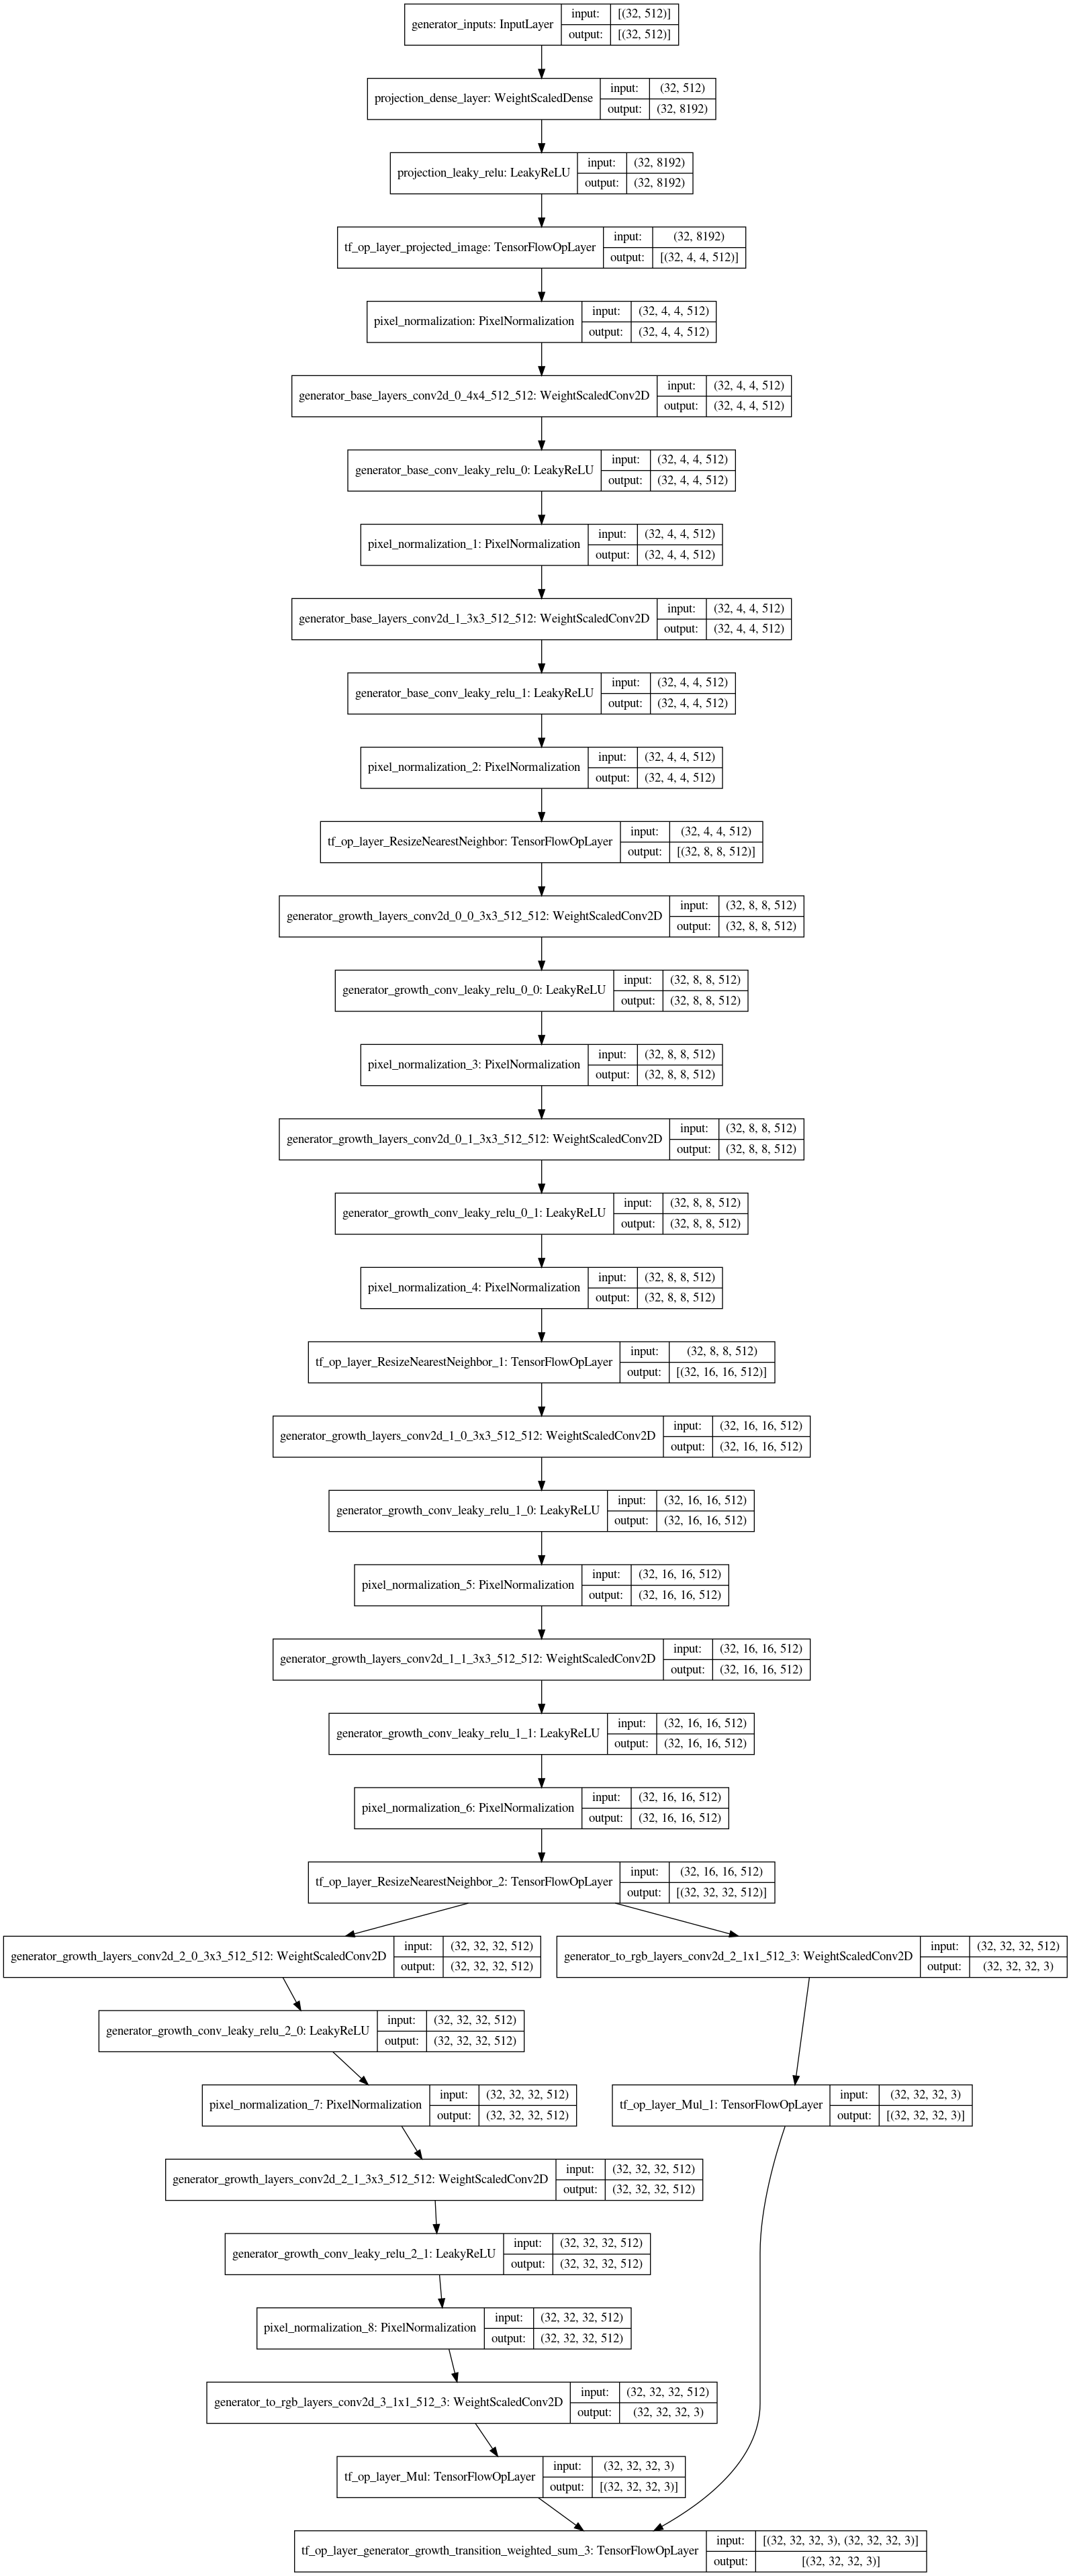

In [14]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=generator_model,
    to_file="generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [15]:
generator_model.__dict__

{'_self_setattr_tracking': True,
 '_trainable': True,
 '_stateful': False,
 'built': True,
 '_build_input_shape': TensorShape([32, 512]),
 '_saved_model_inputs_spec': TensorSpec(shape=(32, 512), dtype=tf.float32, name='generator_inputs'),
 '_input_spec': None,
 '_supports_masking': True,
 '_name': 'generator_growth_transition_3',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x7fa6877324d0>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7fa6301e0780>,
 '_dtype_policy': <Policy "float32", loss_scale=None>,
 '_dtype_defaulted_to_floatx': True,
 '_compute_dtype_object': tf.float32,
 '_autocast': False,
 '_layers': [<tensorflow.python.keras.engine.input_layer.InputLayer at 0x7fa6b8e9e210>,
 '_inbound_nodes': [],
 '_outbound_nodes': [],
 '_expects_training_arg': True,
 '_default_training_arg': None,
 '_expects_mask_arg': True,
 '_

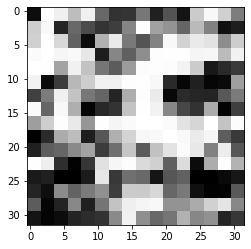

In [16]:
noise = tf.random.normal(shape=[10, arguments["generator_latent_size"]])
fake_images = generator_model(inputs=noise, training=False)

plt.imshow(fake_images[0, :, :, 0], cmap='gray')

## discriminators.py

In [17]:
class Discriminator(object):
    """Discriminator that takes image input and outputs logits.

    Attributes:
        name: str, name of `Discriminator`.
        kernel_regularizer: `l1_l2_regularizer` object, regularizar for
            kernel variables.
        bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
            variables.
        params: dict, user passed parameters.
        alpha_var: variable, alpha for weighted sum of fade-in of layers.
        from_rgb_conv_layers: list, `Conv2D` fromRGB layers.
        from_rgb_leaky_relu_layers: list, leaky relu layers that follow
            `Conv2D` fromRGB layers.
        conv_layers: list, `Conv2D` layers.
        leaky_relu_layers: list, leaky relu layers that follow `Conv2D`
            layers.
        growing_downsample_layers: list, `AveragePooling2D` layers for growing
            branch.
        shrinking_downsample_layers: list, `AveragePooling2D` layers for
            shrinking branch.
        flatten_layer: `Flatten` layer, flattens image for logits layer.
        logits_layer: `Dense` layer, used for calculating logits.
        model: instance of discriminator `Model`.
    """
    def __init__(
        self,
        kernel_regularizer,
        bias_regularizer,
        name,
        params,
        alpha_var
    ):
        """Instantiates and builds discriminator network.

        Args:
            kernel_regularizer: `l1_l2_regularizer` object, regularizar for
                kernel variables.
            bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
                variables.
            name: str, name of discriminator.
            params: dict, user passed parameters.
            alpha_var: variable, alpha for weighted sum of fade-in of layers.
        """
        # Set name of discriminator.
        self.name = name

        # Store regularizers.
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer

        # Store parameters.
        self.params = params

        # Store reference to alpha variable.
        self.alpha_var = alpha_var

        # Store lists of layers.
        self.from_rgb_conv_layers = []
        self.from_rgb_leaky_relu_layers = []

        self.conv_layers = []
        self.leaky_relu_layers = []

        self.growing_downsample_layers = []
        self.shrinking_downsample_layers = []

        self.flatten_layer = None
        self.logits_layer = None

        # Instantiate discriminator layers.
        self._create_discriminator_layers()

        # Store current discriminator model.
        self.model = None

    def _create_from_rgb_layers(self):
        """Creates discriminator fromRGB layers of 1x1 convs.

        Returns:
            List of fromRGB 1x1 conv layers and leaky relu layers.
        """
        # Get fromRGB layer properties.
        from_rgb = [
            self.params["discriminator_from_rgb_layers"][i][0][:]
            for i in range(
                len(self.params["discriminator_from_rgb_layers"])
            )
        ]

        # Create list to hold toRGB 1x1 convs.
        from_rgb_conv_layers = [
            WeightScaledConv2D(
                filters=from_rgb[i][3],
                kernel_size=from_rgb[i][0:2],
                strides=from_rgb[i][4:6],
                padding="same",
                activation=None,
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
                    if self.params["use_equalized_learning_rate"]
                    else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                use_equalized_learning_rate=self.params["use_equalized_learning_rate"],
                name="{}_from_rgb_layers_conv2d_{}_{}x{}_{}_{}".format(
                    self.name,
                    i,
                    from_rgb[i][0],
                    from_rgb[i][1],
                    from_rgb[i][2],
                    from_rgb[i][3]
                )
            )
            for i in range(len(from_rgb))
        ]

        from_rgb_leaky_relu_layers = [
            tf.keras.layers.LeakyReLU(
                alpha=self.params["discriminator_leaky_relu_alpha"],
                name="{}_from_rgb_conv_leaky_relu_{}".format(self.name, i)
            )
            for i in range(len(from_rgb))
        ]

        return from_rgb_conv_layers, from_rgb_leaky_relu_layers

    def _create_base_conv_layer_block(self):
        """Creates discriminator base conv layer block.

        Returns:
            List of base block conv layers and list of leaky relu layers.
        """
        # Get conv block layer properties.
        conv_block = self.params["discriminator_base_conv_blocks"][0]

        # Create list of base conv layers.
        base_conv_layers = [
            WeightScaledConv2D(
                filters=conv_block[i][3],
                kernel_size=conv_block[i][0:2],
                strides=conv_block[i][4:6],
                padding="same",
                activation=None,
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
                    if self.params["use_equalized_learning_rate"]
                    else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                use_equalized_learning_rate=(
                    self.params["use_equalized_learning_rate"]
                ),
                name="{}_base_layers_conv2d_{}_{}x{}_{}_{}".format(
                    self.name,
                    i,
                    conv_block[i][0],
                    conv_block[i][1],
                    conv_block[i][2],
                    conv_block[i][3]
                )
            )
            for i in range(len(conv_block) - 1)
        ]

        # Have valid padding for layer just before flatten and logits.
        base_conv_layers.append(
            WeightScaledConv2D(
                filters=conv_block[-1][3],
                kernel_size=conv_block[-1][0:2],
                strides=conv_block[-1][4:6],
                padding="valid",
                activation=None,
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
                    if self.params["use_equalized_learning_rate"]
                    else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                use_equalized_learning_rate=(
                    self.params["use_equalized_learning_rate"]
                ),
                name="{}_base_layers_conv2d_{}_{}x{}_{}_{}".format(
                    self.name,
                    len(conv_block) - 1,
                    conv_block[-1][0],
                    conv_block[-1][1],
                    conv_block[-1][2],
                    conv_block[-1][3]
                )
            )
        )

        base_leaky_relu_layers = [
            tf.keras.layers.LeakyReLU(
                alpha=self.params["discriminator_leaky_relu_alpha"],
                name="{}_base_conv_leaky_relu_{}".format(self.name, i)
            )
            for i in range(len(conv_block))
        ]

        return base_conv_layers, base_leaky_relu_layers

    def _create_growth_conv_layer_block(self, block_idx):
        """Creates discriminator growth conv layer block.

        Args:
            block_idx: int, the current growth block's index.

        Returns:
            List of growth block's conv layers and list of growth block's
                leaky relu layers.
        """
        # Get conv block layer properties.
        conv_block = self.params["discriminator_growth_conv_blocks"][block_idx]

        # Create new growth convolutional layers.
        growth_conv_layers = [
            WeightScaledConv2D(
                filters=conv_block[i][3],
                kernel_size=conv_block[i][0:2],
                strides=conv_block[i][4:6],
                padding="same",
                activation=None,
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
                    if self.params["use_equalized_learning_rate"]
                    else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                use_equalized_learning_rate=(
                    self.params["use_equalized_learning_rate"]
                ),
                name="{}_growth_layers_conv2d_{}_{}_{}x{}_{}_{}".format(
                    self.name,
                    block_idx,
                    i,
                    conv_block[i][0],
                    conv_block[i][1],
                    conv_block[i][2],
                    conv_block[i][3]
                )
            )
            for i in range(len(conv_block))
        ]

        growth_leaky_relu_layers = [
            tf.keras.layers.LeakyReLU(
                alpha=self.params["discriminator_leaky_relu_alpha"],
                name="{}_growth_conv_leaky_relu_{}_{}".format(
                    self.name, block_idx, i
                )
            )
            for i in range(len(conv_block))
        ]

        return growth_conv_layers, growth_leaky_relu_layers

    def _create_downsample_layers(self):
        """Creates discriminator downsample layers.

        Returns:
            Lists of AveragePooling2D layers for growing and shrinking
                branches.
        """
        # Create list to hold growing branch's downsampling layers.
        growing_downsample_layers = [
            tf.keras.layers.AveragePooling2D(
                pool_size=(2, 2),
                strides=(2, 2),
                name="{}_growing_average_pooling_2d_{}".format(
                    self.name, i - 1
                )
            )
            for i in range(
                1, len(self.params["discriminator_from_rgb_layers"])
            )
        ]

        # Create list to hold shrinking branch's downsampling layers.
        shrinking_downsample_layers = [
            tf.keras.layers.AveragePooling2D(
                pool_size=(2, 2),
                strides=(2, 2),
                name="{}_shrinking_average_pooling_2d_{}".format(
                    self.name, i - 1
                )
            )
            for i in range(
                1, len(self.params["discriminator_from_rgb_layers"])
            )
        ]

        return growing_downsample_layers, shrinking_downsample_layers

    def _create_discriminator_layers(self):
        """Creates discriminator layers.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
        """
        (self.from_rgb_conv_layers,
         self.from_rgb_leaky_relu_layers) = self._create_from_rgb_layers()

        (base_conv_layers,
         base_leaky_relu_layers) = self._create_base_conv_layer_block()
        self.conv_layers.append(base_conv_layers)
        self.leaky_relu_layers.append(base_leaky_relu_layers)

        for block_idx in range(
            len(self.params["discriminator_growth_conv_blocks"])
        ):
            (growth_conv_layers,
             growth_leaky_relu_layers
             ) = self._create_growth_conv_layer_block(block_idx)

            self.conv_layers.append(growth_conv_layers)
            self.leaky_relu_layers.append(growth_leaky_relu_layers)

        (self.growing_downsample_layers,
         self.shrinking_downsample_layers) = self._create_downsample_layers()

        self.flatten_layer = tf.keras.layers.Flatten()

        self.logits_layer = WeightScaledDense(
            units=1,
            activation=None,
            kernel_initializer=(
                tf.random_normal_initializer(mean=0., stddev=1.0)
                if self.params["use_equalized_learning_rate"]
                else "he_normal"
            ),
            kernel_regularizer=self.kernel_regularizer,
            bias_regularizer=self.bias_regularizer,
            use_equalized_learning_rate=(
                self.params["use_equalized_learning_rate"]
            ),
            name="{}_layers_dense_logits".format(self.name)
        )

    def minibatch_stddev_common(self, variance, tile_multiples):
        """Adds minibatch stddev feature map to image using grouping.

        This is the code that is common between the grouped and ungroup
        minibatch stddev functions.

        Args:
            variance: tensor, variance of minibatch or minibatch groups.
            tile_multiples: list, length 4, used to tile input to final shape
                input_dims[i] * mutliples[i].

        Returns:
            Minibatch standard deviation feature map image added to
                channels of shape
                [batch_size, image_height, image_width, 1].
        """
        # Calculate standard deviation over the group plus small epsilon.
        # shape = (
        #     {"grouped": batch_size / group_size, "ungrouped": 1},
        #     image_size,
        #     image_size,
        #     num_channels
        # )
        stddev = tf.sqrt(x=variance + 1e-8, name="minibatch_stddev")

        # Take average over feature maps and pixels.
        if self.params["discriminator_minibatch_stddev_averaging"]:
            # grouped shape = (batch_size / group_size, 1, 1, 1)
            # ungrouped shape = (1, 1, 1, 1)
            stddev = tf.reduce_mean(
                input_tensor=stddev,
                axis=[1, 2, 3],
                keepdims=True,
                name="minibatch_stddev_average"
            )

        # Replicate over group and pixels.
        # shape = (batch_size, image_size, image_size, 1)
        stddev_feature_map = tf.tile(
            input=stddev,
            multiples=tile_multiples,
            name="minibatch_stddev_feature_map"
        )

        return stddev_feature_map

    def grouped_minibatch_stddev(self, inputs, batch_size, group_size):
        """Adds minibatch stddev feature map to image using grouping.

        Args:
            inputs: tf.float32 tensor, image of shape
                [batch_size, image_height, image_width, num_channels].
            batch_size: tf.int64 tensor, the dynamic batch size (in case
                of partial batch).
            group_size: int, size of image groups.

        Returns:
            Minibatch standard deviation feature map image added to
                channels of shape
                [batch_size, image_height, image_width, 1].
        """
        # The group size should be less than or equal to the batch size.
        group_size = tf.minimum(x=group_size, y=batch_size)

        # Split minibatch into M groups of size group_size, rank 5 tensor.
        # shape = (
        #     group_size,
        #     batch_size / group_size,
        #     image_size,
        #     image_size,
        #     num_channels
        # )
        grouped_image = tf.reshape(
            tensor=inputs,
            shape=[group_size, -1] + list(inputs.shape[1:]),
            name="grouped_image"
        )

        # Find the mean of each group.
        # shape = (
        #     1,
        #     batch_size / group_size,
        #     image_size,
        #     image_size,
        #     num_channels
        # )
        grouped_mean = tf.reduce_mean(
            input_tensor=grouped_image,
            axis=0,
            keepdims=True,
            name="grouped_mean"
        )

        # Center each group using the mean.
        # shape = (
        #     group_size,
        #     batch_size / group_size,
        #     image_size,
        #     image_size,
        #     num_channels
        # )
        centered_grouped_image = tf.subtract(
            x=grouped_image, y=grouped_mean, name="centered_grouped_image"
        )

        # Calculate variance over group.
        # shape = (
        #     batch_size / group_size, image_size, image_size, num_channels
        # )
        grouped_variance = tf.reduce_mean(
            input_tensor=tf.square(x=centered_grouped_image),
            axis=0,
            name="grouped_variance"
        )

        # Get stddev image using ops common to both grouped & ungrouped.
        tile_multiples = [group_size] + list(inputs.shape[1:3]) + [1]
        stddev_feature_map = self.minibatch_stddev_common(
            variance=grouped_variance, tile_multiples=tile_multiples
        )

        return stddev_feature_map

    def ungrouped_minibatch_stddev(self, inputs, batch_size):
        """Adds minibatch stddev feature map added to image channels.

        Args:
            inputs: tensor, image of shape
                [batch_size, image_height, image_width, num_channels].
            batch_size: tf.int64 tensor, the dynamic batch size (in case
                of partial batch).

        Returns:
            Minibatch standard deviation feature map image added to
                channels of shape
                [batch_size, image_height, image_width, 1].
        """
        # Find the mean of each group.
        # shape = (1, image_size, image_size, num_channels)
        mean = tf.reduce_mean(
            input_tensor=inputs, axis=0, keepdims=True, name="mean"
        )

        # Center each group using the mean.
        # shape = (batch_size, image_size, image_size, num_channels)
        centered_image = tf.subtract(
            x=inputs, y=mean, name="centered_image"
        )

        # Calculate variance over group.
        # shape = (1, image_size, image_size, num_channels)
        variance = tf.reduce_mean(
            input_tensor=tf.square(x=centered_image),
            axis=0,
            keepdims=True,
            name="variance"
        )

        # Get stddev image using ops common to both grouped & ungrouped.
        tile_multiples = [batch_size] + list(inputs.shape[1:3]) + [1]
        stddev_feature_map = self.minibatch_stddev_common(
            variance=variance, tile_multiples=tile_multiples
        )

        return stddev_feature_map

    def minibatch_stddev(self, inputs, group_size=4):
        """Adds minibatch stddev feature map added to image.

        Args:
            inputs: tensor, image of shape
                [batch_size, image_height, image_width, num_channels].
            group_size: int, size of image groups.

        Returns:
            Image with minibatch standard deviation feature map added to
                channels of shape
                [batch_size, image_height, image_width, num_channels + 1].
        """
        # Get batch size.
        batch_size = inputs.shape[0]

        if (batch_size % group_size == 0 or batch_size < group_size):
            stddev_feature_map = self.grouped_minibatch_stddev(
                inputs=inputs, batch_size=batch_size, group_size=group_size
            )
        else:
            stddev_feature_map = self.ungrouped_minibatch_stddev(
                inputs=inputs, batch_size=batch_size
            )

        # Append new feature map to image.
        # shape = (batch_size, image_height, image_width, num_channels + 1)
        appended_image = tf.concat(
            values=[inputs, stddev_feature_map],
            axis=-1,
            name="appended_image"
        )

        return appended_image

    def _use_logits_layer(self, inputs):
        """Uses flatten and logits layers to get logits tensor.

        Args:
            inputs: tensor, output of last conv layer of discriminator.

        Returns:
            Final logits tensor of discriminator.
        """
        # Set shape to remove ambiguity for dense layer.
        inputs.set_shape(
            [
                inputs.get_shape()[0],
                self.params["generator_projection_dims"][0] // 4,
                self.params["generator_projection_dims"][1] // 4,
                inputs.get_shape()[-1]]
        )

        # Flatten final block conv tensor.
        flat_inputs = self.flatten_layer(inputs=inputs)

        # Final linear layer for logits.
        logits = self.logits_layer(inputs=flat_inputs)

        return logits

    def _create_base_block_and_logits(self, inputs):
        """Creates base discriminator block and logits.

        Args:
            block_conv: tensor, output of previous `Conv2D` block's layer.

        Returns:
            Final logits tensor of discriminator.
        """
        # Only need the first conv layer block for base network.
        base_conv_layers = self.conv_layers[0]
        base_leaky_relu_layers = self.leaky_relu_layers[0]

        network = inputs
        if self.params["discriminator_use_minibatch_stddev"]:
            network = self.minibatch_stddev(
                inputs=network,
                group_size=(
                    self.params["discriminator_minibatch_stddev_group_size"]
                )
            )
        for i in range(len(base_conv_layers)):
            network = base_conv_layers[i](inputs=network)
            network = base_leaky_relu_layers[i](inputs=network)

        # Get logits now.
        logits = self._use_logits_layer(inputs=network)

        return logits

    def _create_growth_transition_weighted_sum(self, inputs, block_idx):
        """Creates growth transition img_to_vec weighted_sum.

        Args:
            inputs: tensor, input image to discriminator.
            block_idx: int, current block index of model progression.

        Returns:
            Tensor of weighted sum between shrinking and growing block paths.
        """
        # Growing side chain.
        growing_from_rgb_conv_layer = self.from_rgb_conv_layers[block_idx]
        growing_from_rgb_leaky_relu_layer = (
            self.from_rgb_leaky_relu_layers[block_idx]
        )
        growing_downsample_layer = (
            self.growing_downsample_layers[block_idx - 1]
        )

        growing_conv_layers = self.conv_layers[block_idx]
        growing_leaky_relu_layers = self.leaky_relu_layers[block_idx]

        # Pass inputs through layer chain.
        network = growing_from_rgb_conv_layer(inputs=inputs)
        network = growing_from_rgb_leaky_relu_layer(inputs=network)

        for i in range(len(growing_conv_layers)):
            network = growing_conv_layers[i](inputs=network)
            network = growing_leaky_relu_layers[i](inputs=network)

        # Down sample from 2s X 2s to s X s image.
        growing_network = growing_downsample_layer(inputs=network)

        # Shrinking side chain.
        shrinking_from_rgb_conv_layer = (
            self.from_rgb_conv_layers[block_idx - 1]
        )
        shrinking_from_rgb_leaky_relu_layer = (
            self.from_rgb_leaky_relu_layers[block_idx - 1]
        )
        shrinking_downsample_layer = (
            self.shrinking_downsample_layers[block_idx - 1]
        )

        # Pass inputs through layer chain.
        # Down sample from 2s X 2s to s X s image.
        network = shrinking_downsample_layer(inputs=inputs)

        network = shrinking_from_rgb_conv_layer(inputs=network)
        shrinking_network = shrinking_from_rgb_leaky_relu_layer(
            inputs=network
        )

        # Weighted sum.
        weighted_sum = tf.add(
            x=growing_network * self.alpha_var,
            y=shrinking_network * (1.0 - self.alpha_var),
            name="{}_growth_transition_weighted_sum_{}".format(
                self.name, block_idx
            )
        )

        return weighted_sum

    def _create_perm_growth_block_network(self, inputs, block_idx):
        """Creates discriminator permanent block network.

        Args:
            inputs: tensor, output of previous block's layer.
            block_idx: int, current block index of model progression.

        Returns:
            Tensor from final permanent block `Conv2D` layer.
        """
        # Get permanent growth blocks, so skip the base block.
        permanent_conv_layers = self.conv_layers[1:block_idx]
        permanent_leaky_relu_layers = self.leaky_relu_layers[1:block_idx]
        permanent_downsample_layers = self.growing_downsample_layers[0:block_idx - 1]

        # Reverse order of blocks.
        permanent_conv_layers = permanent_conv_layers[::-1]
        permanent_leaky_relu_layers = permanent_leaky_relu_layers[::-1]
        permanent_downsample_layers = permanent_downsample_layers[::-1]

        # Pass inputs through layer chain.
        network = inputs

        # Loop through the permanent growth blocks.
        for i in range(len(permanent_conv_layers)):
            # Get layers from ith permanent block.
            conv_layers = permanent_conv_layers[i]
            leaky_relu_layers = permanent_leaky_relu_layers[i]
            permanent_downsample_layer = permanent_downsample_layers[i]

            # Loop through layers of ith permanent block.
            for j in range(len(conv_layers)):
                network = conv_layers[j](inputs=network)
                network = leaky_relu_layers[j](inputs=network)

            # Down sample from 2s X 2s to s X s image.
            network = permanent_downsample_layer(inputs=network)

        return network

    def _build_base_model(self, input_shape, batch_size):
        """Builds discriminator base model.

        Args:
            input_shape: tuple, shape of image vector input of shape
                [batch_size, height, width, depth].
            batch_size: int, fixed number of examples within batch.

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to discriminator.
        # shape = (batch_size, height, width, depth)
        inputs = tf.keras.Input(
            shape=input_shape,
            batch_size=batch_size,
            name="{}_inputs".format(self.name)
        )

        # Only need the first fromRGB conv layer & block for base network.
        base_from_rgb_conv_layer = self.from_rgb_conv_layers[0]
        base_from_rgb_leaky_relu_layer = self.from_rgb_leaky_relu_layers[0]

        base_conv_layers = self.conv_layers[0]
        base_leaky_relu_layers = self.leaky_relu_layers[0]

        # Pass inputs through layer chain.
        network = base_from_rgb_conv_layer(inputs=inputs)
        network = base_from_rgb_leaky_relu_layer(inputs=network)

        # Get logits after continuing through base conv block.
        logits = self._create_base_block_and_logits(inputs=network)

        # Define model.
        model = tf.keras.Model(
            inputs=inputs,
            outputs=logits,
            name="{}_base".format(self.name)
        )

        return model

    def _build_growth_transition_model(
        self, input_shape, batch_size, block_idx
    ):
        """Builds discriminator growth transition model.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, height, width, depth].
            batch_size: int, fixed number of examples within batch.
            block_idx: int, current block index of model progression.

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to discriminator.
        # shape = (batch_size, height, width, depth)
        inputs = tf.keras.Input(
            shape=input_shape,
            batch_size=batch_size,
            name="{}_inputs".format(self.name)
        )

        # Get weighted sum between shrinking and growing block paths.
        weighted_sum = self._create_growth_transition_weighted_sum(
            inputs=inputs, block_idx=block_idx
        )

        # Get output of final permanent growth block's last `Conv2D` layer.
        network = self._create_perm_growth_block_network(
            inputs=weighted_sum, block_idx=block_idx
        )

        # Get logits after continuing through base conv block.
        logits = self._create_base_block_and_logits(inputs=network)

        # Define model.
        model = tf.keras.Model(
            inputs=inputs,
            outputs=logits,
            name="{}_growth_transition_{}".format(self.name, block_idx)
        )

        return model

    def _build_growth_stable_model(self, input_shape, batch_size, block_idx):
        """Builds generator growth stable model.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
            batch_size: int, fixed number of examples within batch.
            block_idx: int, current block index of model progression.

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to generator.
        # shape = (batch_size, latent_size)
        inputs = tf.keras.Input(
            shape=input_shape,
            batch_size=batch_size,
            name="{}_inputs".format(self.name)
        )

        # Get fromRGB layers.
        from_rgb_conv_layer = self.from_rgb_conv_layers[block_idx]
        from_rgb_leaky_relu_layer = self.from_rgb_leaky_relu_layers[block_idx]

        # Pass inputs through layer chain.
        network = from_rgb_conv_layer(inputs=inputs)
        network = from_rgb_leaky_relu_layer(inputs=network)

        # Get output of final permanent growth block's last `Conv2D` layer.
        network = self._create_perm_growth_block_network(
            inputs=network, block_idx=block_idx + 1
        )

        # Get logits after continuing through base conv block.
        logits = self._create_base_block_and_logits(inputs=network)

        # Define model.
        model = tf.keras.Model(
            inputs=inputs,
            outputs=logits,
            name="{}_growth_stable_{}".format(self.name, block_idx)
        )

        return model

    def get_model(self, input_shape, batch_size, growth_idx):
        """Returns discriminator's `Model` object.

        Args:
            input_shape: tuple, shape of image input of shape
                [batch_size, height, width, depth].
            batch_size: int, fixed number of examples within batch.
            growth_idx: int, index of current growth stage.
                0 = base,
                odd = growth transition,
                even = growth stability.

        Returns:
            Discriminator's `Model` object.
        """
        block_idx = (growth_idx + 1) // 2
        if growth_idx == 0:
            self.model = self._build_base_model(input_shape, batch_size)
        elif growth_idx % 2 == 1:
            self.model = self._build_growth_transition_model(
                input_shape, batch_size, block_idx
            )
        elif growth_idx % 2 == 0:
            self.model = self._build_growth_stable_model(
                input_shape, batch_size, block_idx
            )
        else:
            print("ERROR: Bad growth index!")

        return self.model

    def get_gradient_penalty_loss(self, fake_images, real_images):
        """Gets discriminator gradient penalty loss.

        Args:
            fake_images: tensor, images generated by the generator from random
                noise of shape [batch_size, image_size, image_size, 3].
            real_images: tensor, real images from input of shape
                [batch_size, image_height, image_width, 3].

        Returns:
            Discriminator's gradient penalty loss of shape [].
        """
        batch_size = real_images.shape[0]

        # Get a random uniform number rank 4 tensor.
        random_uniform_num = tf.random.uniform(
            shape=[batch_size, 1, 1, 1],
            minval=0., maxval=1.,
            dtype=tf.float32,
            name="gp_random_uniform_num"
        )

        # Find the element-wise difference between images.
        image_difference = fake_images - real_images

        # Get random samples from this mixed image distribution.
        mixed_images = random_uniform_num * image_difference
        mixed_images += real_images

        # Get loss from interpolated mixed images and watch for gradients.
        with tf.GradientTape() as gp_tape:
            # Watch interpolated mixed images.
            gp_tape.watch(tensor=mixed_images)

            # Send to the discriminator to get logits.
            mixed_logits = self.model(inputs=mixed_images, training=True)

            # Get the mixed loss.
            mixed_loss = tf.reduce_sum(
                input_tensor=mixed_logits,
                name="gp_mixed_loss"
            )

        # Get gradient from returned list of length 1.
        mixed_gradients = gp_tape.gradient(
            target=mixed_loss, sources=[mixed_images]
        )[0]

        # Get gradient's L2 norm.
        mixed_norms = tf.sqrt(
            x=tf.reduce_sum(
                input_tensor=tf.square(
                    x=mixed_gradients,
                    name="gp_squared_grads"
                ),
                axis=[1, 2, 3]
            ) + 1e-8
        )

        # Get squared difference from target of 1.0.
        squared_difference = tf.square(
            x=mixed_norms - 1.0, name="gp_squared_difference"
        )

        # Get gradient penalty scalar.
        gradient_penalty = tf.reduce_mean(
            input_tensor=squared_difference, name="gp_gradient_penalty"
        )

        # Multiply with lambda to get gradient penalty loss.
        gradient_penalty_loss = tf.multiply(
            x=self.params["discriminator_gradient_penalty_coefficient"],
            y=gradient_penalty,
            name="gp_gradient_penalty_loss"
        )

        return gradient_penalty_loss

    def get_discriminator_loss(
        self,
        global_batch_size,
        fake_images,
        real_images,
        fake_logits,
        real_logits,
        global_step,
        summary_file_writer
    ):
        """Gets discriminator loss.

        Args:
            global_batch_size: int, global batch size for distribution.
            fake_images: tensor, images generated by the generator from random
                noise of shape [batch_size, image_size, image_size, 3].
            real_images: tensor, real images from input of shape
                [batch_size, image_height, image_width, 3].
            fake_logits: tensor, output of discriminator using fake images
                with shape [batch_size, 1].
            real_logits: tensor, output of discriminator using real images
                with shape [batch_size, 1].
            global_step: int, current global step for training.
            summary_file_writer: summary file writer.

        Returns:
            Tensor of discriminator's total loss of shape [].
        """
        if self.params["distribution_strategy"]:
            # Calculate base discriminator loss.
            discriminator_fake_loss = tf.nn.compute_average_loss(
                per_example_loss=fake_logits,
                global_batch_size=global_batch_size
            )

            discriminator_real_loss = tf.nn.compute_average_loss(
                per_example_loss=real_logits,
                global_batch_size=global_batch_size
            )
        else:
            # Calculate base discriminator loss.
            discriminator_fake_loss = tf.reduce_mean(
                input_tensor=fake_logits,
                name="{}_fake_loss".format(self.name)
            )

            discriminator_real_loss = tf.reduce_mean(
                input_tensor=real_logits,
                name="{}_real_loss".format(self.name)
            )

        discriminator_loss = tf.subtract(
            x=discriminator_fake_loss,
            y=discriminator_real_loss,
            name="{}_loss".format(self.name)
        )

        # Get discriminator gradient penalty loss.
        discriminator_gradient_penalty = self.get_gradient_penalty_loss(
            fake_images=fake_images, real_images=real_images
        )

        # Get discriminator epsilon drift penalty.
        epsilon_drift_penalty = tf.multiply(
            x=self.params["discriminator_epsilon_drift"],
            y=tf.reduce_mean(input_tensor=tf.square(x=real_logits)),
            name="epsilon_drift_penalty"
        )

        # Get discriminator Wasserstein GP loss.
        discriminator_wasserstein_gp_loss = tf.add_n(
            inputs=[
                discriminator_loss,
                discriminator_gradient_penalty,
                epsilon_drift_penalty
            ],
            name="{}_wasserstein_gp_loss".format(self.name)
        )

        if self.params["distribution_strategy"]:
            # Get regularization losses.
            discriminator_reg_loss = tf.nn.scale_regularization_loss(
                regularization_loss=sum(self.model.losses)
            )
        else:
            # Get regularization losses.
            discriminator_reg_loss = sum(self.model.losses)

        # Combine losses for total loss.
        discriminator_total_loss = tf.math.add(
            x=discriminator_wasserstein_gp_loss,
            y=discriminator_reg_loss,
            name="discriminator_total_loss"
        )

        if self.params["write_summaries"]:
            # Add summaries for TensorBoard.
            with summary_file_writer.as_default():
                with tf.summary.record_if(
                    condition=tf.equal(
                        x=tf.math.floormod(
                            x=global_step,
                            y=self.params["save_summary_steps"]
                        ), y=0
                    )
                ):
                    tf.summary.scalar(
                        name="losses/discriminator_real_loss",
                        data=discriminator_real_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/discriminator_fake_loss",
                        data=discriminator_fake_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/discriminator_loss",
                        data=discriminator_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/discriminator_gradient_penalty",
                        data=discriminator_gradient_penalty,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/epsilon_drift_penalty",
                        data=epsilon_drift_penalty,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/discriminator_wasserstein_gp_loss",
                        data=discriminator_wasserstein_gp_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/discriminator_reg_loss",
                        data=discriminator_reg_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="optimized_losses/discriminator_total_loss",
                        data=discriminator_total_loss,
                        step=global_step
                    )
                    summary_file_writer.flush()

        return discriminator_total_loss


In [18]:
# Instantiate discriminator.
pgan_discriminator = Discriminator(
    kernel_regularizer=tf.keras.regularizers.l1_l2(
        l1=arguments["discriminator_l1_regularization_scale"],
        l2=arguments["discriminator_l2_regularization_scale"]
    ),
    bias_regularizer=None,
    name="discriminator",
    params=arguments,
    alpha_var=tf.Variable(
        initial_value=tf.zeros(shape=[], dtype=tf.float32),
        trainable=False,
        name="alpha_var"
    )
)

# Define discriminator model.
height, width = arguments["generator_projection_dims"][0:2]
discriminator_model = pgan_discriminator.get_model(
    input_shape=(
        height * (2 ** (num_conv_blocks - 1)),
        width * (2 ** (num_conv_blocks - 1)),
        arguments["depth"]
    ),
    batch_size=arguments["train_batch_size"],
    growth_idx=max(0, (num_conv_blocks - 1) * 2 - transition)
)

In [19]:
# Summarize discriminator model.
discriminator_model.summary()

Model: "discriminator_growth_transition_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_inputs (InputLaye [(32, 32, 32, 3)]    0                                            
__________________________________________________________________________________________________
discriminator_from_rgb_layers_c (32, 32, 32, 512)    2048        discriminator_inputs[0][0]       
__________________________________________________________________________________________________
discriminator_from_rgb_conv_lea (32, 32, 32, 512)    0           discriminator_from_rgb_layers_con
__________________________________________________________________________________________________
discriminator_growth_layers_con (32, 32, 32, 512)    2359808     discriminator_from_rgb_conv_leaky
__________________________________________________________________

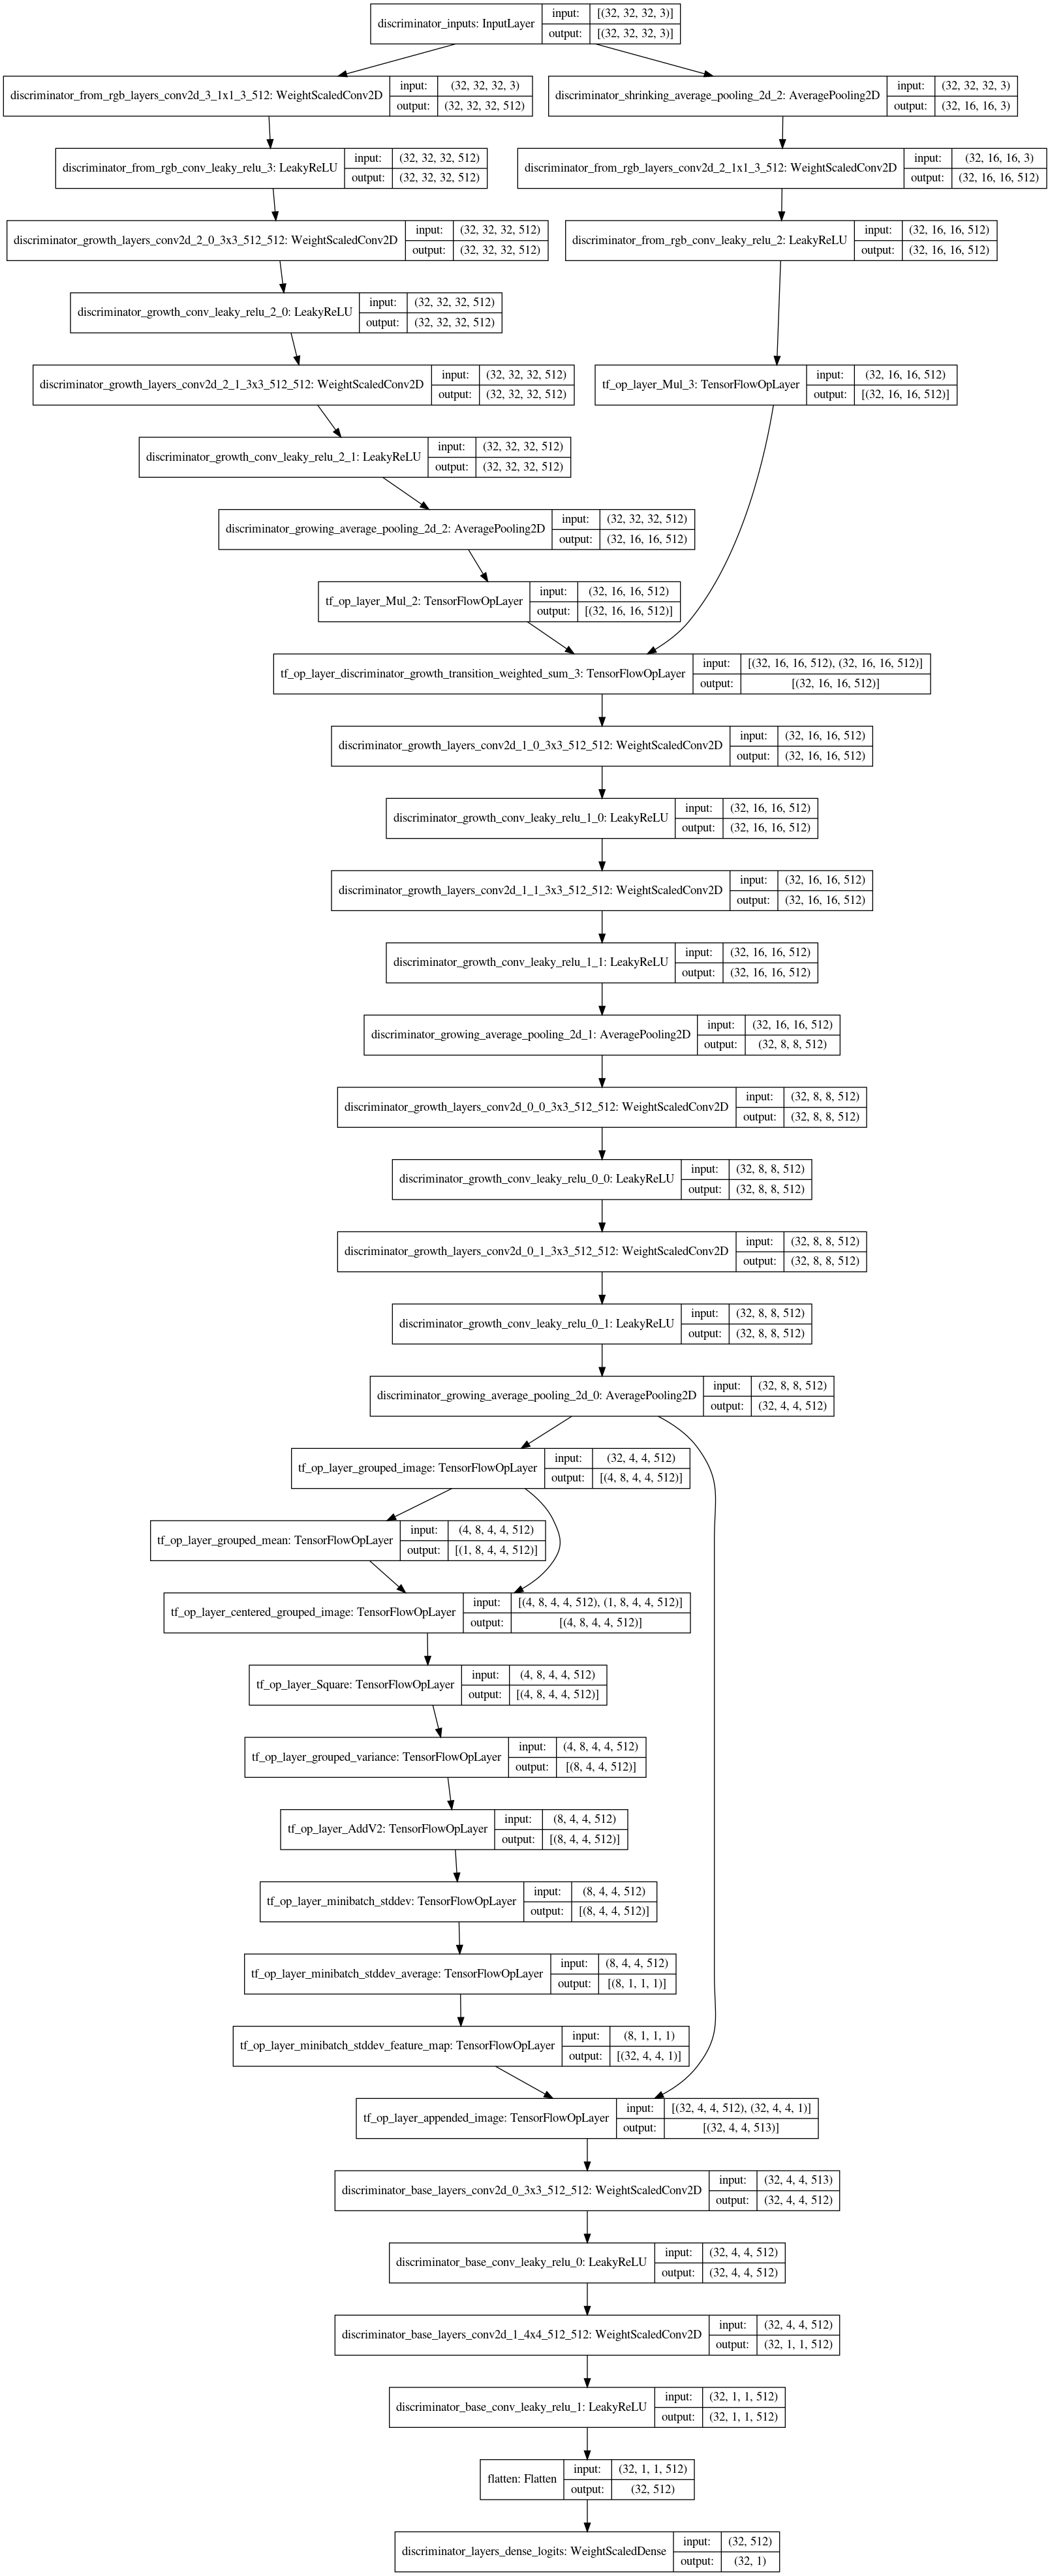

In [20]:
# Plot discriminator model.
tf.keras.utils.plot_model(
    model=discriminator_model,
    to_file="discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [21]:
discriminator_model.__dict__

{'_self_setattr_tracking': True,
 '_trainable': True,
 '_stateful': False,
 'built': True,
 '_build_input_shape': TensorShape([32, 32, 32, 3]),
 '_saved_model_inputs_spec': TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float32, name='discriminator_inputs'),
 '_input_spec': None,
 '_supports_masking': True,
 '_name': 'discriminator_growth_transition_3',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x7fa6efd89410>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7fa6efd1a690>,
 '_dtype_policy': <Policy "float32", loss_scale=None>,
 '_dtype_defaulted_to_floatx': True,
 '_compute_dtype_object': tf.float32,
 '_autocast': False,
 '_layers': [<tensorflow.python.keras.engine.input_layer.InputLayer at 0x7fa6eff1f690>,
 '_inbound_nodes': [],
 '_outbound_nodes': [],
 '_expects_training_arg': True,
 '_default_training_arg': None,
 '_expects_

## train_and_eval.py

In [22]:
class TrainAndEval(object):
    """Class that contains methods used for both training and evaluation.
    """
    def __init__(self):
        """Instantiate instance of `TrainAndEval`.
        """
        pass

    def generator_loss_phase(self, mode, training):
        """Gets fake logits and loss for generator.

        Args:
            mode: str, what mode currently in: TRAIN or EVAL.
            training: bool, if model should be training.

        Returns:
            Fake images tensor of shape
                [batch_size, iamge_height, image_width, image_depth], fake
                logits tensor of shape [batch_size, 1], and generator loss
                tensor of shape [].
        """
        batch_size = (
            self.params["train_batch_size"]
            if mode == "TRAIN"
            else self.params["eval_batch_size"]
        )

        # Create random noise latent vector for each batch example.
        Z = tf.random.normal(
            shape=[batch_size, self.params["generator_latent_size"]],
            mean=0.0,
            stddev=1.0,
            dtype=tf.float32
        )

        # Get generated image from generator network from gaussian noise.
        fake_images = self.network_models["generator"](
            inputs=Z, training=training
        )

        if self.params["write_summaries"] and mode == "TRAIN":
            # Add summaries for TensorBoard.
            with self.summary_file_writer.as_default():
                with tf.summary.record_if(
                condition=tf.equal(
                    x=tf.math.floormod(
                        x=self.global_step,
                        y=self.params["save_summary_steps"]
                    ), y=0
                )
                ):
                    tf.summary.image(
                        name="fake_images",
                        data=fake_images,
                        step=self.global_step,
                        max_outputs=5
                    )
                    self.summary_file_writer.flush()

        # Get fake logits from discriminator using generator's output image.
        fake_logits = self.network_models["discriminator"](
            inputs=fake_images, training=training
        )

        # Get generator total loss.
        generator_total_loss = (
            self.network_objects["generator"].get_generator_loss(
                global_batch_size=self.global_batch_size,
                fake_logits=fake_logits,
                global_step=self.global_step,
                summary_file_writer=self.summary_file_writer
            )
        )

        return fake_images, fake_logits, generator_total_loss

    def discriminator_loss_phase(
        self, fake_images, real_images, fake_logits, training
    ):
        """Gets real logits and loss for discriminator.

        Args:
            fake_images: tensor, images generated by the generator from random
                noise of shape [batch_size, image_size, image_size, 3].
            real_images: tensor, real images from input of shape
                [batch_size, image_height, image_width, 3].
            fake_logits: tensor, output of discriminator using fake images
                with shape [batch_size, 1].
            training: bool, if in training mode.

        Returns:
            Real logits of shape [batch_size, 1] and discriminator loss of
                shape [].
        """
        # Get real logits from discriminator using real image.
        real_logits = self.network_models["discriminator"](
            inputs=real_images, training=training
        )

        # Get discriminator total loss.
        discriminator_total_loss = (
            self.network_objects["discriminator"].get_discriminator_loss(
                global_batch_size=self.global_batch_size,
                fake_images=fake_images,
                real_images=real_images,
                fake_logits=fake_logits,
                real_logits=real_logits,
                global_step=self.global_step,
                summary_file_writer=self.summary_file_writer
            )
        )

        return real_logits, discriminator_total_loss


## train.py

In [23]:
class Train(object):
    """Class that contains methods used for only training.
    """
    def __init__(self):
        """Instantiate instance of `Train`.
        """
        pass

    def get_variables_and_gradients(self, loss, gradient_tape, scope):
        """Gets variables and gradients from model wrt. loss.

        Args:
            loss: tensor, shape of [].
            gradient_tape: instance of `GradientTape`.
            scope: str, the name of the network of interest.

        Returns:
            Lists of network's variables and gradients.
        """
        # Get trainable variables.
        variables = self.network_models[scope].trainable_variables

        # Get gradients from gradient tape.
        gradients = gradient_tape.gradient(
            target=loss, sources=variables
        )

        # Clip gradients.
        if self.params["{}_clip_gradients".format(scope)]:
            gradients, _ = tf.clip_by_global_norm(
                t_list=gradients,
                clip_norm=self.params["{}_clip_gradients".format(scope)],
                name="{}_clip_by_global_norm_gradients".format(scope)
            )

        # Add variable names back in for identification.
        gradients = [
            tf.identity(
                input=g,
                name="{}_{}_gradients".format(scope, v.name[:-2])
            )
            if tf.is_tensor(x=g) else g
            for g, v in zip(gradients, variables)
        ]

        return variables, gradients

    def create_variable_and_gradient_histogram_summaries(
        self, variables, gradients, scope
    ):
        """Creates variable and gradient histogram summaries.

        Args:
            variables: list, network's trainable variables.
            gradients: list, gradients of network's trainable variables wrt.
                loss.
            scope: str, the name of the network of interest.
        """
        if self.params["write_summaries"]:
            # Add summaries for TensorBoard.
            with self.summary_file_writer.as_default():
                with tf.summary.record_if(
                    condition=tf.equal(
                        x=tf.math.floormod(
                            x=self.global_step,
                            y=self.params["save_summary_steps"]
                        ), y=0
                    )
                ):
                    for v, g in zip(variables, gradients):
                        tf.summary.histogram(
                            name="{}_variables/{}".format(
                                scope, v.name[:-2]
                            ),
                            data=v,
                            step=self.global_step
                        )
                        if tf.is_tensor(x=g):
                            tf.summary.histogram(
                                name="{}_gradients/{}".format(
                                    scope, v.name[:-2]
                                ),
                                data=g,
                                step=self.global_step
                            )
                    self.summary_file_writer.flush()

    def get_select_loss_variables_and_gradients(self, real_images, scope):
        """Gets selected network's loss, variables, and gradients.

        Args:
            real_images: tensor, real images of shape
                [batch_size, height * width * depth].
            scope: str, the name of the network of interest.

        Returns:
            Selected network's loss, variables, and gradients.
        """
        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            # Get fake logits from generator.
            (fake_images,
             fake_logits,
             generator_loss) = self.generator_loss_phase(
                mode="TRAIN", training=True
            )

            # Get discriminator loss.
            _, discriminator_loss = self.discriminator_loss_phase(
                fake_images, real_images, fake_logits, training=True
            )

        # Create empty dicts to hold loss, variables, gradients.
        loss_dict = {}
        vars_dict = {}
        grads_dict = {}

        # Loop over generator and discriminator.
        for (loss, gradient_tape, scope_name) in zip(
            [generator_loss, discriminator_loss],
            [gen_tape, dis_tape],
            ["generator", "discriminator"]
        ):
            # Get variables and gradients from generator wrt. loss.
            variables, gradients = self.get_variables_and_gradients(
                loss, gradient_tape, scope_name
            )

            # Add loss, variables, and gradients to dictionaries.
            loss_dict[scope_name] = loss
            vars_dict[scope_name] = variables
            grads_dict[scope_name] = gradients

            # Create variable and gradient histogram summaries.
            self.create_variable_and_gradient_histogram_summaries(
                variables, gradients, scope_name
            )

        return loss_dict[scope], vars_dict[scope], grads_dict[scope]

    def train_network(self, variables, gradients, scope):
        """Trains network variables using gradients with optimizer.

        Args:
            variables: list, network's trainable variables.
            gradients: list, gradients of network's trainable variables wrt.
                loss.
            scope: str, the name of the network of interest.
        """
        # Zip together gradients and variables.
        grads_and_vars = zip(gradients, variables)

        # Applying gradients to variables using optimizer.
        self.optimizers[scope].apply_gradients(grads_and_vars=grads_and_vars)

    def resize_real_images(self, images):
        """Resizes real images to match the GAN's current size.

        Args:
            images: tensor, original images.

        Returns:
            Resized image tensor.
        """
        block_idx = (self.growth_idx + 1) // 2
        height, width = self.params["generator_projection_dims"][0:2]
        resized_image = tf.image.resize(
            images=images,
            size=[
                height * (2 ** block_idx), width * (2 ** block_idx)
            ],
            method="nearest",
            name="resized_image_{}".format(self.growth_idx)
        )

        return resized_image

    def train_discriminator(self, features):
        """Trains discriminator network.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Discriminator loss tensor.
        """
        # Extract real images from features dictionary.
        real_images = self.resize_real_images(images=features["image"])

        # Get gradients for training by running inputs through networks.
        loss, variables, gradients = (
            self.get_select_loss_variables_and_gradients(
                real_images, scope="discriminator"
            )
        )

        # Train discriminator network.
        self.train_network(variables, gradients, scope="discriminator")

        return loss

    def train_generator(self, features):
        """Trains generator network.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Generator loss tensor.
        """
        # Extract real images from features dictionary.
        real_images = self.resize_real_images(images=features["image"])

        # Get gradients for training by running inputs through networks.
        loss, variables, gradients = (
            self.get_select_loss_variables_and_gradients(
                real_images, scope="generator"
            )
        )

        # Train generator network.
        self.train_network(variables, gradients, scope="generator")

        return loss

    def create_checkpoint_machinery(self):
        """Creates checkpoint machinery needed to save & restore checkpoints.
        """
        # Create checkpoint instance.
        checkpoint_dir = os.path.join(
            self.params["output_dir"], "checkpoints"
        )
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

        max_growth_idx = (len(self.params["conv_num_filters"]) - 1) * 2
        image_multiplier = 2 ** ((max_growth_idx + 1) // 2)
        height, width = self.params["generator_projection_dims"][0:2]

        checkpoint = tf.train.Checkpoint(
            generator_model=self.network_objects["generator"].get_model(
                input_shape=(self.params["generator_latent_size"]),
                batch_size=1,
                growth_idx=max_growth_idx
            ),
            discriminator_model=(
                self.network_objects["discriminator"].get_model(
                    input_shape=(
                        height * image_multiplier,
                        width * image_multiplier,
                        self.params["depth"]
                    ),
                    batch_size=1,
                    growth_idx=max_growth_idx
                )
            ),
            generator_optimizer=self.optimizers["generator"],
            discriminator_optimizer=self.optimizers["discriminator"]
        )

        # Create checkpoint manager.
        self.checkpoint_manager = tf.train.CheckpointManager(
            checkpoint=checkpoint,
            directory=checkpoint_dir,
            max_to_keep=self.params["keep_checkpoint_max"],
            step_counter=self.global_step,
            checkpoint_interval=self.params["save_checkpoints_steps"]
        )

        # Restore any prior checkpoints.
        status = checkpoint.restore(
            save_path=self.checkpoint_manager.latest_checkpoint
        )

    def prepare_training_components(self):
        """Prepares all components necessary for training.
        """
        # Instantiate model objects.
        self.instantiate_model_objects()

        # Create checkpoint machinery to save/restore checkpoints.
        self.create_checkpoint_machinery()

        # Create summary file writer.
        self.summary_file_writer = tf.summary.create_file_writer(
            logdir=os.path.join(self.params["output_dir"], "summaries"),
            name="summary_file_writer"
        )

    def set_active_network_models(self):
        """Sets active network models for current growth phase.
        """
        self.network_models["generator"] = (
            self.network_objects["generator"].get_model(
                input_shape=(self.params["generator_latent_size"]),
                batch_size=self.params["train_batch_size"],
                growth_idx=self.growth_idx
            )
        )

        image_multiplier = 2 ** ((self.growth_idx + 1) // 2)
        height = (
            self.params["generator_projection_dims"][0] * image_multiplier
        )
        width = (
            self.params["generator_projection_dims"][1] * image_multiplier
        )
        self.network_models["discriminator"] = (
            self.network_objects["discriminator"].get_model(
                    input_shape=(height, width, self.params["depth"]
                ),
                batch_size=self.params["train_batch_size"],
                growth_idx=self.growth_idx
            )
        )


## instantiate_model.py

In [24]:
class InstantiateModel(object):
    """Class that contains methods used for instantiating model objects.
    """
    def __init__(self):
        """Instantiate instance of `InstantiateModel`.
        """
        pass

    def instantiate_network_objects(self):
        """Instantiates generator and discriminator with parameters.
        """
        # Instantiate generator.
        self.network_objects["generator"] = Generator(
            kernel_regularizer=tf.keras.regularizers.l1_l2(
                l1=self.params["generator_l1_regularization_scale"],
                l2=self.params["generator_l2_regularization_scale"]
            ),
            bias_regularizer=None,
            name="generator",
            params=self.params,
            alpha_var=self.alpha_var
        )

        # Instantiate discriminator.
        self.network_objects["discriminator"] = Discriminator(
            kernel_regularizer=tf.keras.regularizers.l1_l2(
                l1=self.params["discriminator_l1_regularization_scale"],
                l2=self.params["discriminator_l2_regularization_scale"]
            ),
            bias_regularizer=None,
            name="discriminator",
            params=self.params,
            alpha_var=self.alpha_var
        )

    def instantiate_optimizer(self, scope):
        """Instantiates optimizer with parameters.

        Args:
            scope: str, the name of the network of interest.
        """
        # Create optimizer map.
        optimizers = {
            "Adadelta": tf.keras.optimizers.Adadelta,
            "Adagrad": tf.keras.optimizers.Adagrad,
            "Adam": tf.keras.optimizers.Adam,
            "Adamax": tf.keras.optimizers.Adamax,
            "Ftrl": tf.keras.optimizers.Ftrl,
            "Nadam": tf.keras.optimizers.Nadam,
            "RMSprop": tf.keras.optimizers.RMSprop,
            "SGD": tf.keras.optimizers.SGD
        }

        # Get optimizer and instantiate it.
        if self.params["{}_optimizer".format(scope)] == "Adam":
            optimizer = optimizers[self.params["{}_optimizer".format(scope)]](
                learning_rate=self.params["{}_learning_rate".format(scope)],
                beta_1=self.params["{}_adam_beta1".format(scope)],
                beta_2=self.params["{}_adam_beta2".format(scope)],
                epsilon=self.params["{}_adam_epsilon".format(scope)],
                name="{}_{}_optimizer".format(
                    scope, self.params["{}_optimizer".format(scope)].lower()
                )
            )
        else:
            optimizer = optimizers[self.params["{}_optimizer".format(scope)]](
                learning_rate=self.params["{}_learning_rate".format(scope)],
                name="{}_{}_optimizer".format(
                    scope, self.params["{}_optimizer".format(scope)].lower()
                )
            )

        self.optimizers[scope] = optimizer

    def instantiate_model_objects(self):
        """Instantiate model network objects, network models, and optimizers.
        """
        # Instantiate generator and discriminator objects.
        self.instantiate_network_objects()

        # Instantiate generator optimizer.
        self.instantiate_optimizer(scope="generator")

        # Instantiate discriminator optimizer.
        self.instantiate_optimizer(scope="discriminator")


## train_step.py

In [25]:
class TrainStep(object):
    """Class that contains methods concerning train steps.
    """
    def __init__(self):
        """Instantiate instance of `TrainStep`.
        """
        pass

    def distributed_eager_discriminator_train_step(self, features):
        """Perform one distributed, eager discriminator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        if self.params["tf_version"] > 2.1:
            run_function = self.strategy.run
        else:
            run_function = self.strategy.experimental_run_v2

        per_replica_losses = run_function(
            fn=self.train_discriminator, kwargs={"features": features}
        )

        return self.strategy.reduce(
            reduce_op=tf.distribute.ReduceOp.SUM,
            value=per_replica_losses,
            axis=None
        )

    def non_distributed_eager_discriminator_train_step(self, features):
        """Perform one non-distributed, eager discriminator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        return self.train_discriminator(features=features)

    @tf.function
    def distributed_graph_discriminator_train_step(self, features):
        """Perform one distributed, graph discriminator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        if self.params["tf_version"] > 2.1:
            run_function = self.strategy.run
        else:
            run_function = self.strategy.experimental_run_v2

        per_replica_losses = run_function(
            fn=self.train_discriminator, kwargs={"features": features}
        )

        return self.strategy.reduce(
            reduce_op=tf.distribute.ReduceOp.SUM,
            value=per_replica_losses,
            axis=None
        )

    @tf.function
    def non_distributed_graph_discriminator_train_step(self, features):
        """Perform one non-distributed, graph discriminator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        return self.train_discriminator(features=features)

    def distributed_eager_generator_train_step(self, features):
        """Perform one distributed, eager generator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        if self.params["tf_version"] > 2.1:
            run_function = self.strategy.run
        else:
            run_function = self.strategy.experimental_run_v2

        per_replica_losses = run_function(
            fn=self.train_generator, kwargs={"features": features}
        )

        return self.strategy.reduce(
            reduce_op=tf.distribute.ReduceOp.SUM,
            value=per_replica_losses,
            axis=None
        )

    def non_distributed_eager_generator_train_step(self, features):
        """Perform one non-distributed, eager generator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        return self.train_generator(features=features)

    @tf.function
    def distributed_graph_generator_train_step(self, features):
        """Perform one distributed, graph generator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        if self.params["tf_version"] > 2.1:
            run_function = self.strategy.run
        else:
            run_function = self.strategy.experimental_run_v2

        per_replica_losses = run_function(
            fn=self.train_generator, kwargs={"features": features}
        )

        return self.strategy.reduce(
            reduce_op=tf.distribute.ReduceOp.SUM,
            value=per_replica_losses,
            axis=None
        )

    @tf.function
    def non_distributed_graph_generator_train_step(self, features):
        """Perform one non-distributed, graph generator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        return self.train_generator(features=features)

    def get_train_step_functions(self):
        """Gets network model train step functions for strategy and mode.
        """
        if self.strategy:
            if self.params["use_graph_mode"]:
                self.discriminator_train_step_fn = (
                    self.distributed_graph_discriminator_train_step
                )
                self.generator_train_step_fn = (
                    self.distributed_graph_generator_train_step
                )
            else:
                self.discriminator_train_step_fn = (
                    self.distributed_eager_discriminator_train_step
                )
                self.generator_train_step_fn = (
                    self.distributed_eager_generator_train_step
                )
        else:
            if self.params["use_graph_mode"]:
                self.discriminator_train_step_fn = (
                    self.non_distributed_graph_discriminator_train_step
                )
                self.generator_train_step_fn = (
                    self.non_distributed_graph_generator_train_step
                )
            else:
                self.discriminator_train_step_fn = (
                    self.non_distributed_eager_discriminator_train_step
                )
                self.generator_train_step_fn = (
                    self.non_distributed_eager_generator_train_step
                )

    def log_step_loss(self, epoch, loss):
        """Logs step information and loss.

        Args:
            epoch: int, current iteration fully through the dataset.
            loss: float, the loss of the model at the current step.
        """
        if self.global_step % self.params["log_step_count_steps"] == 0:
            start_time = self.previous_timestamp
            self.previous_timestamp = tf.timestamp()
            elapsed_time = self.previous_timestamp - start_time
            print(
                "{} = {}, {} = {}, {} = {}, {} = {}, {} = {}".format(
                    "epoch",
                    epoch,
                    "global_step",
                    self.global_step.numpy(),
                    "epoch_step",
                    self.epoch_step,
                    "steps/sec",
                    float(self.params["log_step_count_steps"]) / elapsed_time,
                    "loss",
                    loss,
                )
            )

    @tf.function
    def increment_global_step(self):
        """Increments global step variable.
        """
        self.global_step.assign_add(
            delta=tf.ones(shape=[], dtype=tf.int64)
        )

    @tf.function
    def increment_alpha_var(self):
        """Increments alpha variable through range [0., 1.] during transition.
        """
        self.alpha_var.assign(
            value=tf.divide(
                x=tf.cast(
                    x=tf.math.floormod(
                        x=self.global_step,
                        y=self.params["num_steps_until_growth"]
                    ),
                    dtype=tf.float32
                ),
                y=self.params["num_steps_until_growth"]
            )
        )

    def network_model_training_steps(
        self,
        epoch,
        train_step_fn,
        train_steps,
        train_dataset_iter,
        features,
        labels
    ):
        """Trains a network model for so many steps given a set of features.

        Args:
            epoch: int, the current iteration through the dataset.
            train_step_fn: unbound function, trains the given network model
                given a set of features.
            train_steps: int, number of steps to train network model.
            train_dataset_iter: iterator, training dataset iterator.
            features: dict, feature tensors from input function.
            labels: tensor, label tensor from input function.

        Returns:
            Bool that indicates if current growth phase complete,
                dictionary of most recent feature tensors, and most recent
                label tensor.
        """
        for _ in range(train_steps):
            if features is None:
                # Train model on batch of features and get loss.
                features, labels = next(train_dataset_iter)

            loss = train_step_fn(features=features)

            # Log step information and loss.
            self.log_step_loss(epoch, loss)

            # Checkpoint model every save_checkpoints_steps steps.
            self.checkpoint_manager.save(
                checkpoint_number=self.global_step, check_interval=True
            )

            # Increment steps.
            self.increment_global_step()
            self.epoch_step += 1

            # If this is a growth transition phase.
            if self.growth_idx % 2 == 1:
                # Increment alpha variable.
                self.increment_alpha_var()

            if self.global_step % self.params["num_steps_until_growth"] == 0:
                return True, features, labels
        return False, features, labels


## training_loop.py

In [26]:
class TrainingLoop(object):
    """Class that contains methods for training loop.
    """
    def __init__(self):
        """Instantiate instance of `TrainStep`.
        """
        pass

    def training_loop(self, steps_per_epoch, train_dataset_iter):
        """Loops through training dataset to train model.

        Args:
            steps_per_epoch: int, number of steps/batches to take each epoch.
            train_dataset_iter: iterator, training dataset iterator.
        """
        # Get correct train function based on parameters.
        self.get_train_step_functions()

        # Calculate number of growths. Each progression involves 2 growths,
        # a transition phase and stablization phase.
        num_growths = len(self.params["conv_num_filters"]) * 2 - 1

        for self.growth_idx in range(num_growths):
            print("\ngrowth_idx = {}".format(self.growth_idx))

            # Set active generator and discriminator `Model`s.
            self.set_active_network_models()

            for epoch in range(self.params["num_epochs"]):
                self.previous_timestamp = tf.timestamp()

                self.epoch_step = 0
                while self.epoch_step < steps_per_epoch:
                    # Train discriminator.
                    (growth_phase_complete,
                     features,
                     labels) = self.network_model_training_steps(
                        epoch=epoch,
                        train_step_fn=self.discriminator_train_step_fn,
                        train_steps=self.params["discriminator_train_steps"],
                        train_dataset_iter=train_dataset_iter,
                        features=None,
                        labels=None
                    )

                    if growth_phase_complete:
                        break  # break while loop

                    # Train generator.
                    (growth_phase_complete,
                     _,
                     _) = self.network_model_training_steps(
                        epoch=epoch,
                        train_step_fn=self.generator_train_step_fn,
                        train_steps=self.params["generator_train_steps"],
                        train_dataset_iter=None,
                        features=features,
                        labels=labels
                    )

                    if growth_phase_complete:
                        break  # break while loop

                if growth_phase_complete:
                    break  # break epoch for loop

            if self.params["export_every_growth_phase"]:
                self.export_saved_model()


## export.py

In [27]:
class Export(object):
    """Class that contains methods used for exporting model objects.
    """
    def __init__(self):
        """Instantiate instance of `Export`.
        """
        pass

    def export_saved_model(self):
        """Exports SavedModel to output directory for serving.
        """
        export_path = os.path.join(
            self.params["output_dir"],
            "export",
            datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        )

        # Signature will be serving_default.
        tf.saved_model.save(
            obj=self.network_models["generator"], export_dir=export_path
        )

    def training_loop_end_save_model(self):
        """Saving model when training loop ends.
        """
        # Write final checkpoint.
        self.checkpoint_manager.save(
            checkpoint_number=self.global_step, check_interval=False
        )

        # Export SavedModel for serving.
        self.export_saved_model()

    def training_loop_end_save_model(self):
        """Saving model when training loop ends.
        """
        # Write final checkpoint.
        self.checkpoint_manager.save(
            checkpoint_number=self.global_step, check_interval=False
        )

        # Export SavedModel for serving.
        export_path = os.path.join(
            self.params["output_dir"],
            "export",
            datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        )

        # Signature will be serving_default.
        tf.saved_model.save(
            obj=self.network_models["generator"], export_dir=export_path
        )


## model.py

In [28]:
class TrainAndEvaluateModel(
    TrainAndEval,
    Train,
    InstantiateModel,
    TrainStep,
    TrainingLoop,
    Export
):
    """Train and evaluate loop trainer for model.

    Attributes:
        params: dict, user passed parameters.
        network_objects: dict, instances of `Generator` and `Discriminator`
            network objects.
        network_models: dict, instances of Keras `Model`s for each network.
        optimizers: dict, instances of Keras `Optimizer`s for each network.
        strategy: instance of tf.distribute.strategy.
        discriminator_train_step_fn: unbound function, function for a
            dicriminator train step using correct strategy and mode.
        generator_train_step_fn: unbound function, function for a
            generator train step using correct strategy and mode.
        global_batch_size: int, the global batch size after summing batch
            sizes across replicas.
        global_step: tf.Variable, the global step counter across epochs and
            steps within epoch.
        alpha_var: tf.Variable, used in growth transition network's weighted
            sum.
        summary_file_writer: instance of tf.summary.create_file_writer for
            summaries for TensorBoard.
        growth_idx: int, current growth index model has progressed to.
        epoch_step: int, the current step through current epoch.
        previous_timestamp: float, the previous timestamp for profiling the
            steps/sec rate.
    """
    def __init__(self, params):
        """Instantiate trainer.

        Args:
            params: dict, user passed parameters.
        """
        super().__init__()
        self.params = params

        self.network_objects = {}
        self.network_models = {}
        self.optimizers = {}

        self.strategy = None

        self.discriminator_train_step_fn = None
        self.generator_train_step_fn = None

        self.global_batch_size = None

        self.global_step = tf.Variable(
            initial_value=tf.zeros(shape=[], dtype=tf.int64),
            trainable=False,
            name="global_step"
        )

        self.alpha_var = tf.Variable(
            initial_value=tf.zeros(shape=[], dtype=tf.float32),
            trainable=False,
            name="alpha_var"
        )

        self.summary_file_writer = None

        self.growth_idx = 0
        self.epoch_step = 0
        self.previous_timestamp = 0.0

    def get_train_eval_datasets(self, num_replicas):
        """Gets train and eval datasets.

        Args:
            num_replicas: int, number of device replicas.

        Returns:
            Train and eval datasets.
        """
        train_dataset = read_dataset(
            filename=self.params["train_file_pattern"],
            batch_size=self.params["train_batch_size"] * num_replicas,
            params=self.params,
            training=True
        )()

        eval_dataset = read_dataset(
            filename=self.params["eval_file_pattern"],
            batch_size=self.params["eval_batch_size"] * num_replicas,
            params=self.params,
            training=False
        )()
        if self.params["eval_steps"]:
            eval_dataset = eval_dataset.take(count=self.params["eval_steps"])

        return train_dataset, eval_dataset

    def train_block(self, train_dataset, eval_dataset):
        """Training block setups training, then loops through datasets.

        Args:
            train_dataset: instance of `Dataset` for training data.
            eval_dataset: instance of `Dataset` for evaluation data.
        """
        # Create iterators of datasets.
        train_dataset_iter = iter(train_dataset)
        eval_dataset_iter = iter(eval_dataset)

        steps_per_epoch = (
            self.params["train_dataset_length"] // self.global_batch_size
        )

        # Instantiate models, create checkpoints, create summary file writer.
        self.prepare_training_components()

        # Run training loop.
        self.training_loop(steps_per_epoch, train_dataset_iter)

        # Save model at end of training loop.
        self.training_loop_end_save_model()

    def train_and_evaluate(self):
        """Trains and evaluates Keras model.

        Args:
            args: dict, user passed parameters.

        Returns:
            Generator's `Model` object for in-memory predictions.
        """
        if self.params["distribution_strategy"]:
            # If the list of devices is not specified in the
            # Strategy constructor, it will be auto-detected.
            if self.params["distribution_strategy"] == "Mirrored":
                self.strategy = tf.distribute.MirroredStrategy()
            print(
                "Number of devices = {}".format(
                    self.strategy.num_replicas_in_sync
                )
            )

            # Set global batch size for training.
            self.global_batch_size = (
                self.params["train_batch_size"] * self.strategy.num_replicas_in_sync
            )

            # Get input datasets. Batch size is split evenly between replicas.
            train_dataset, eval_dataset = self.get_train_eval_datasets(
                num_replicas=self.strategy.num_replicas_in_sync
            )

            with self.strategy.scope():
                # Create distributed datasets.
                train_dist_dataset = (
                    self.strategy.experimental_distribute_dataset(
                        dataset=train_dataset
                    )
                )
                eval_dist_dataset = (
                    self.strategy.experimental_distribute_dataset(
                        dataset=eval_dataset
                    )
                )

                # Training block setups training, then loops through datasets.
                self.train_block(
                    train_dataset=train_dist_dataset,
                    eval_dataset=eval_dist_dataset
                )
        else:
            # Set global batch size for training.
            self.global_batch_size = self.params["train_batch_size"]

            # Get input datasets.
            train_dataset, eval_dataset = self.get_train_eval_datasets(
                num_replicas=1
            )

            # Training block setups training, then loops through datasets.
            self.train_block(
                train_dataset=train_dataset, eval_dataset=eval_dataset
            )


## Run model

In [29]:
os.environ["OUTPUT_DIR"] = arguments["output_dir"]

In [ ]:
%%bash
gsutil -m rm -rf ${OUTPUT_DIR}

In [32]:
train_and_evaluate_model = TrainAndEvaluateModel(params=arguments)

In [33]:
train_and_evaluate_model.train_and_evaluate()

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.

growth_idx = 0
epoch = 0, global_step = 0, epoch_step = 0, steps/sec = 14.574495029828466, loss = 1.2576031684875488
epoch = 0, global_step = 100, epoch_step = 100, steps/sec = 10.189862691227072, loss = -2.4157958030700684
epoch = 0, global_step = 200, epoch_step = 200, steps/sec = 28.936483984948048, loss = -2.6916239261627197
epoch = 0, global_step = 300, epoch_step = 300, steps/sec = 28.876079719466567, loss = -1.8524343967437744
epoch = 1, global_step = 400, epoch_step = 88, steps/sec = 32.03738738078128, loss = -2.2981278896331787
epoch = 1, global_step = 500, epoch_step = 188, steps/sec = 28.61912560647474, loss = -2.4799399375915527
epoch = 1, global_step = 600, epoch_step = 288, steps/sec = 28.508595357432384, loss = -1.9634274244308472
epoc

In [34]:
!gsutil ls ${OUTPUT_DIR}

gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/export/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/summaries/


In [35]:
!gsutil ls ${OUTPUT_DIR}/checkpoints

gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/checkpoint
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-0.data-00000-of-00001
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-0.index
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-10000.data-00000-of-00001
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-10000.index
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-20000.data-00000-of-00001
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-20000.index
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-30000.data-00000-of-00001
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-30000.index
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/c

In [36]:
!gsutil ls ${OUTPUT_DIR}/summaries

gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/summaries/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/summaries/events.out.tfevents.1596791089.tensorflow-2-3-20200728-220626.32138.2061.v2


## Prediction

In [37]:
!gsutil ls ${OUTPUT_DIR}/export

gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/export/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/export/20200807090758/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/export/20200807091100/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/export/20200807091406/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/export/20200807091709/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/export/20200807092015/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/export/20200807092318/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/export/20200807092625/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/export/20200807092637/


In [38]:
loaded = tf.saved_model.load(
    export_dir=os.path.join(
        arguments["output_dir"], "export", "20200807092637"
    )
)
print(list(loaded.signatures.keys()))

['serving_default']


In [39]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'generator_to_rgb_layers_conv2d_3_1x1_512_3': TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float32, name='generator_to_rgb_layers_conv2d_3_1x1_512_3')}


In [40]:
Z = tf.random.normal(shape=(10, 512))
predictions = infer(Z)

In [41]:
predictions.keys()

dict_keys(['generator_to_rgb_layers_conv2d_3_1x1_512_3'])

Convert image back to the original scale.

In [42]:
generated_images = np.clip(
    a=tf.cast(
        x=((predictions[list(predictions.keys())[0]] + 1.0) * (255. / 2)),
        dtype=tf.int32
    ),
    a_min=0,
    a_max=255
)

In [43]:
print(generated_images.shape)

(10, 32, 32, 3)


In [44]:
def plot_images(images, args):
    """Plots images.

    Args:
        images: np.array, array of images of
            [num_images, image_size, image_size, num_channels].
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        image = images[i]
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if args["depth"] == 1:
            plt.imshow(
                tf.reshape(image, image.shape[:-1]), cmap="gray_r"
            )
        elif args["depth"] == 3:
            plt.imshow(image, cmap=plt.cm.binary)
    plt.show()


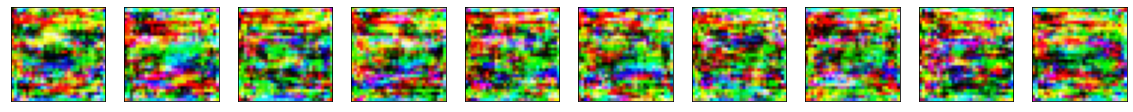

In [45]:
plot_images(images=generated_images, args=arguments)